In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
import keras
from PIL import Image 
import tensorflow as tf
import keras.backend as K
from keras.applications import Xception
from keras.layers import UpSampling2D, Conv2D, Activation, LeakyReLU, BatchNormalization
from keras.optimizers import RMSprop
from keras import Model
from keras.models import load_model
from keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tqdm import tqdm_notebook

Using TensorFlow backend.


### The Data

In [2]:
df_train = pd.read_csv('./input/severstal-steel-defect-detection/train.csv')

In [3]:
df_train['Defect'] = df_train['EncodedPixels'].notnull()
df_train['ClassId'] = df_train['ImageId_ClassId'].str[-1:]
df_train['ImageId'] = df_train['ImageId_ClassId'].str[:-2]

df_train = df_train[['ImageId','ClassId','Defect','EncodedPixels']]

In [4]:
df_train = df_train[df_train.Defect]
df_train = df_train.drop(['Defect'], axis=1)

In [5]:
df_train.shape

(7095, 3)

In [6]:
df_train.head(10)

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
18,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
20,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
27,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
30,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
46,0025bde0c.jpg,3,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...
47,0025bde0c.jpg,4,315139 8 315395 15 315651 16 315906 17 316162 ...
51,002af848d.jpg,4,290800 6 291055 13 291311 15 291566 18 291822 ...
56,002fc4e19.jpg,1,146021 3 146275 10 146529 40 146783 46 147038 ...
57,002fc4e19.jpg,2,145658 7 145901 20 146144 33 146386 47 146629 ...


### Utility functions

In [7]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

In [8]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def rle2mask(rle, width, height):
    width = width
    height= height
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

### Model in Keras

In [29]:
ORIG_IMG_SIZE_HEIGHT = 256
ORIG_IMG_SIZE_WIDTH = 1600
TRAIN_IMG_SIZE_HEIGHT = 128
TRAIN_IMG_SIZE_WIDTH = 800

BATCH_SIZE = 6

NO_OF_CLASSES = 4

PATIENCE = 2
EPOCHS = 2


In [10]:
from skimage.filters import unsharp_mask

# Data generator with preprocessing
class ImgDataGenerator_V3_4(keras.utils.Sequence):
    
    def __init__(self, df, img_path, outcome_img_shape, batch_size = 1, n_channels=1, n_classes=1, 
                 img_normalize=False, img_center = False, img_standardize = False, 
                 shear_range=0.0, zoom_range=0.0,
                 rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, 
                 horizontal_flip=False, vertical_flip=False, 
                 use_unsharp_mask=False, unsharp_radius=1.0, unsharp_amount=1.0,
                 shuffle=False):
        super().__init__()
        self.df = df
        self.img_path = img_path
        self.outcome_img_shape = outcome_img_shape
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.img_normalize = img_normalize
        self.img_center = img_center
        self.img_standardize = img_standardize
        self.use_unsharp_mask = use_unsharp_mask
        self.unsharp_radius = unsharp_radius
        self.unsharp_amount = unsharp_amount
        self.shuffle = shuffle
        self.datagen_img = ImageDataGenerator(samplewise_center=img_center, samplewise_std_normalization=img_standardize, 
                                          rescale=1./255 if img_normalize else 1,
                                          shear_range=shear_range, zoom_range=zoom_range,
                                          rotation_range=rotation_range,
                                          width_shift_range=width_shift_range, height_shift_range=height_shift_range,
                                          horizontal_flip=horizontal_flip, vertical_flip=vertical_flip,
                                          fill_mode = "constant", cval=0, data_format='channels_last', dtype='float32')

        self.datagen_mask = ImageDataGenerator(rescale=1./255 if img_normalize else 1,
                                          shear_range=shear_range, zoom_range=zoom_range,
                                          rotation_range=rotation_range, 
                                          width_shift_range=width_shift_range, height_shift_range=height_shift_range,
                                          horizontal_flip=horizontal_flip, vertical_flip=vertical_flip,
                                          fill_mode = "constant", cval=0, data_format='channels_last', dtype='bool')

        self.on_epoch_end()
    
    
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
        
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size, *self.outcome_img_shape, self.n_channels), dtype=np.float32)
        y = np.empty((self.batch_size, *self.outcome_img_shape, self.n_classes), dtype=np.bool)
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        for idx, filename in enumerate(self.df['ImageId'].iloc[indexes]):
            img = cv2.imread(self.img_path + filename, cv2.IMREAD_UNCHANGED)
            orig_img_shape = img.shape[0:2]
            if self.use_unsharp_mask:
                img = unsharp_mask(img, radius=self.unsharp_radius, amount=self.unsharp_amount)
            if orig_img_shape != self.outcome_img_shape:
                img = cv2.resize(img, tuple(reversed(self.outcome_img_shape)), interpolation=cv2.INTER_AREA)
            X[idx,] = img

            mask = rle2mask(self.df['EncodedPixels'].iloc[indexes[idx]], *orig_img_shape)            
            if orig_img_shape != self.outcome_img_shape:
                mask = cv2.resize(mask, tuple(reversed(self.outcome_img_shape)), interpolation=cv2.INTER_AREA)
            y[idx,:,:,(int(self.df['ClassId'].iloc[indexes[idx]]) - 1)] = mask
         
        seed = 13
        image_generator = self.datagen_img.flow(X, seed=seed, batch_size=self.batch_size, shuffle=False)
        mask_generator = self.datagen_mask.flow(y, seed=seed, batch_size=self.batch_size, shuffle=False)
        
        X_arg = np.empty((self.batch_size*2, *self.outcome_img_shape, self.n_channels), dtype=np.float32)
        y_arg = np.empty((self.batch_size*2, *self.outcome_img_shape, self.n_classes), dtype=np.bool)
        
        
        (X_list, y_list) = zip(image_generator, mask_generator).__next__()
        for i in range(len(X_list)):
            X_arg[i,] = X[i,]
            y_arg[i,:,:,:] = y[i,:,:,:]
            X_arg[i + self.batch_size] = X_list[i]
            y_arg[i + self.batch_size] = y_list[i]

        return X_arg, y_arg

In [11]:
def dice_coeff(y_true, y_pred):
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    loss = 0.5 * binary_crossentropy(y_true, y_pred) - 2*dice_coeff(y_true, y_pred)
    return loss


In [12]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization

def advanced_unet_128x800_segmentation_model(input_shape=(128, 800, 3), num_classes=1):
    inputs = Input(shape=input_shape)

    down_1 = Conv2D(16, (3, 3), padding='same')(inputs)
    down_1 = BatchNormalization()(down_1)
    down_1 = Activation('relu')(down_1)
    down_1 = Conv2D(16, (3, 3), padding='same')(down_1)
    down_1 = BatchNormalization()(down_1)
    down_1 = Activation('relu')(down_1)
    down_1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down_1)
    
    down0 = Conv2D(32, (3, 3), padding='same')(down_1_pool)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0 = Conv2D(32, (3, 3), padding='same')(down0)
    down0 = BatchNormalization()(down0)
    down0 = Activation('relu')(down0)
    down0_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0)

    down1 = Conv2D(64, (3, 3), padding='same')(down0_pool)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(64, (3, 3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)

    down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(128, (3, 3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)

    down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(256, (3, 3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)

    down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4 = Conv2D(512, (3, 3), padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4_pool = MaxPooling2D((2, 1), strides=(2, 1))(down4)

    center = Conv2D(1024, (3, 3), padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Conv2D(1024, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = Activation('relu')(center) # center

    up4 = UpSampling2D((2, 1))(center)
    up4 = concatenate([down4, up4], axis=3)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)

    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2) 

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)

    up0 = UpSampling2D((2, 2))(up1)
    up0 = concatenate([down0, up0], axis=3)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)
    up0 = Conv2D(32, (3, 3), padding='same')(up0)
    up0 = BatchNormalization()(up0)
    up0 = Activation('relu')(up0)

    up_1 = UpSampling2D((2, 2))(up0)
    up_1 = concatenate([down_1, up_1], axis=3)
    up_1 = Conv2D(32, (3, 3), padding='same')(up_1)
    up_1 = BatchNormalization()(up_1)
    up_1 = Activation('relu')(up_1)
    up_1 = Conv2D(32, (3, 3), padding='same')(up_1)
    up_1 = BatchNormalization()(up_1)
    up_1 = Activation('relu')(up_1)
    up_1 = Conv2D(32, (3, 3), padding='same')(up_1)
    up_1 = BatchNormalization()(up_1)
    up_1 = Activation('relu')(up_1)

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up_1)

    model = Model(inputs=inputs, outputs=classify)
    
    return model

In [13]:
advanced_model = advanced_unet_128x800_segmentation_model(num_classes=4)
advanced_model.compile(optimizer=RMSprop(lr=0.0003), loss=bce_dice_loss, metrics=[dice_coeff, 'accuracy'])
advanced_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 800, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 800, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 800, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 800, 16) 0           batch_normalization_1[0][0]      
_____________________________________

activation_11 (Activation)      (None, 4, 25, 512)   0           batch_normalization_11[0][0]     
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 4, 25, 512)   2359808     activation_11[0][0]              
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 4, 25, 512)   2048        conv2d_12[0][0]                  
__________________________________________________________________________________________________
activation_12 (Activation)      (None, 4, 25, 512)   0           batch_normalization_12[0][0]     
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 2, 25, 512)   0           activation_12[0][0]              
__________________________________________________________________________________________________
conv2d_13 

__________________________________________________________________________________________________
activation_22 (Activation)      (None, 16, 100, 128) 0           batch_normalization_22[0][0]     
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 16, 100, 128) 147584      activation_22[0][0]              
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 16, 100, 128) 512         conv2d_23[0][0]                  
__________________________________________________________________________________________________
activation_23 (Activation)      (None, 16, 100, 128) 0           batch_normalization_23[0][0]     
__________________________________________________________________________________________________
up_sampling2d_4 (UpSampling2D)  (None, 32, 200, 128) 0           activation_23[0][0]              
__________

In [14]:
layer = advanced_model.get_layer(index=11)
print(layer.get_config())

{'name': 'conv2d_4', 'trainable': True, 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}


In [15]:
layer = advanced_model.get_layer(name='conv2d_3')
print(layer.get_config())

{'name': 'conv2d_3', 'trainable': True, 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}


In [19]:
# This layer has 3x3x16x32 = 4608 params (weights) 
layer = advanced_model.get_layer(index=11)
layer_128x800_initially = layer.get_weights()[0][2][2][15]
print(layer_128x800_initially)

[ 0.07388982 -0.05202594 -0.04190398 -0.05700328  0.08853178 -0.00875475
 -0.0767741  -0.08205788 -0.03534951  0.02032226 -0.00568679 -0.07314965
 -0.04962568 -0.04348863 -0.07567348  0.05283201 -0.06437978 -0.04150163
  0.03703341  0.06633593  0.04426336  0.02110481 -0.10075048 -0.09363738
 -0.04733334 -0.08024053 -0.08094897  0.01726186  0.02556506  0.04375613
  0.08932471 -0.08328845]


In [ ]:
# This layer has 1x32 = 32 params (weights) 
print(len(layer.get_weights()[1]))

# Combined this model has 4608 + 32 params = 4640 params (weights) as illustrated above for index 11

In [16]:
model_64x400 = load_model('unet_model_64x400_unsharp_4classes.h5', 
                          custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_coeff': dice_coeff})

Instructions for updating:
Use tf.cast instead.


In [17]:
model_64x400.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 400, 3)   0                                            
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 64, 400, 32)  896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, 64, 400, 32)  128         conv2d_29[0][0]                  
__________________________________________________________________________________________________
activation_28 (Activation)      (None, 64, 400, 32)  0           batch_normalization_28[0][0]     
__________________________________________________________________________________________________
conv2d_30 

__________________________________________________________________________________________________
batch_normalization_39 (BatchNo (None, 2, 25, 1024)  4096        conv2d_40[0][0]                  
__________________________________________________________________________________________________
activation_39 (Activation)      (None, 2, 25, 1024)  0           batch_normalization_39[0][0]     
__________________________________________________________________________________________________
up_sampling2d_6 (UpSampling2D)  (None, 4, 25, 1024)  0           activation_39[0][0]              
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 4, 25, 1536)  0           activation_37[0][0]              
                                                                 up_sampling2d_6[0][0]            
__________________________________________________________________________________________________
conv2d_41 

__________________________________________________________________________________________________
activation_49 (Activation)      (None, 32, 200, 64)  0           batch_normalization_49[0][0]     
__________________________________________________________________________________________________
conv2d_51 (Conv2D)              (None, 32, 200, 64)  36928       activation_49[0][0]              
__________________________________________________________________________________________________
batch_normalization_50 (BatchNo (None, 32, 200, 64)  256         conv2d_51[0][0]                  
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 32, 200, 64)  0           batch_normalization_50[0][0]     
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 32, 200, 64)  36928       activation_50[0][0]              
__________

#### Moving weights from low res. sub-model to higher res. including model

We are now going to marry up layers with index 11 to 102 for the advanced_model with the pre-trained weights for the 64x400 model whose indexes are 4 to 95

In [20]:
# Takes roughly a minute
for idx in range(4, 96):
    layer_64x400 = model_64x400.get_layer(index=idx)
    layer_128x800 = advanced_model.get_layer(index=(idx + 7))
    layer_128x800.set_weights(layer_64x400.get_weights())  
    layer_128x800.trainable=False

In [27]:
advanced_model.compile(optimizer=RMSprop(lr=0.0003), loss=bce_dice_loss, metrics=[dice_coeff, 'accuracy'])

In [21]:
layer = advanced_model.get_layer(index=11)
print(layer.get_config())

layer_128x800_initially = layer.get_weights()[0][2][2][15]
print(layer_128x800_initially)

{'name': 'conv2d_4', 'trainable': False, 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
[ 0.08323867  0.00724564 -0.0669409   0.06913392  0.12381848  0.03088861
  0.00234586 -0.01650532 -0.01166312 -0.06177821  0.06149405 -0.06148567
 -0.01162217 -0.02778918 -0.09301718 -0.02690293 -0.0172053  -0.05679335
  0.08459981  0.0354336   0.06441262 -0.0978708  -0.08235308  0.05071042
  0.00045327  0.0039272  -0.08764473  0.05748097 -0.05111419  0.05375233
  0.09408315  0.05531863]


#### Back to training

In [43]:
# A decreasing learning rate schedule (continuous decrease)
def continuous_decay(epoch):
    initial_lrate = 0.01
    lr = initial_lrate * (0.1 ** int(epoch / 10))
    return lr

# Another decreasing learning rate schedule (stepped decrease)
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 5.0
    lr = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr

def get_callback(patient):
    ES = EarlyStopping(
        monitor='loss',
        min_delta = 0.005,
        patience=patient, 
        mode='min', 
        verbose=1)
    RR = ReduceLROnPlateau(
        monitor = 'loss', 
        factor = 0.5, 
        patience = patient//2, 
        min_lr=0.000001, 
        verbose=1, 
        mode='min')
    LR = LearningRateScheduler(
        continuous_decay,
        verbose=1)
    MC = ModelCheckpoint(
        filepath='./unet_model_128x800_unsharp_4classes_v1.h5', 
        save_best_only=True,
        verbose=1)
#    return [ES, RR, LR, MC]
#    return [ES, MC, LR]
    return [ES, MC, RR]


In [30]:
# 1 EPOCH: dice_coeff: 0.2255 - acc: 0.0521 - val_loss: -0.8723 - val_dice_coeff: 0.4503 - val_acc: 0.0488

idx = int(0.8*len(df_train))
dataGen_train = ImgDataGenerator_V3_4(df_train.iloc[:idx], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE, 
                                    n_channels=3, n_classes=4, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5,
                                    shear_range=1, #OK
                                    zoom_range=[0.95,1.05], # OK
                                    rotation_range=1, #OK
                                    width_shift_range=0.015, height_shift_range=0.05,#OK
                                    horizontal_flip=True, vertical_flip=True, #OK
                                    shuffle=False)

dataGen_valid = ImgDataGenerator_V3_4(df_train.iloc[idx:], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE,
                                    n_channels=3, n_classes=4, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5,
                                    shear_range=1, #OK
                                    zoom_range=[0.95,1.05], # OK
                                    rotation_range=1, #OK
                                    width_shift_range=0.015, height_shift_range=0.05,#OK
                                    horizontal_flip=True, vertical_flip=True, #OK
                                    shuffle=False)

history = advanced_model.fit_generator(dataGen_train,
                              epochs=EPOCHS,    
                              validation_data=dataGen_valid,
                              verbose=1,
                              shuffle=True,
                              callbacks = get_callback(PATIENCE)
                             )

Epoch 1/2


132/946 [===>..........................] - ETA: 41:19 - loss: -0.5793 - dice_coeff: 0.3190 - acc: 0.07 - ETA: 38:09 - loss: -0.8235 - dice_coeff: 0.4308 - acc: 0.04 - ETA: 37:07 - loss: -0.9540 - dice_coeff: 0.4922 - acc: 0.04 - ETA: 36:25 - loss: -0.9036 - dice_coeff: 0.4649 - acc: 0.03 - ETA: 35:58 - loss: -0.9184 - dice_coeff: 0.4737 - acc: 0.04 - ETA: 35:48 - loss: -0.8562 - dice_coeff: 0.4416 - acc: 0.03 - ETA: 35:44 - loss: -0.8159 - dice_coeff: 0.4245 - acc: 0.04 - ETA: 35:41 - loss: -0.8633 - dice_coeff: 0.4477 - acc: 0.04 - ETA: 35:35 - loss: -0.8478 - dice_coeff: 0.4395 - acc: 0.04 - ETA: 35:36 - loss: -0.8330 - dice_coeff: 0.4317 - acc: 0.03 - ETA: 35:35 - loss: -0.8173 - dice_coeff: 0.4249 - acc: 0.04 - ETA: 34:35 - loss: -0.8217 - dice_coeff: 0.4264 - acc: 0.03 - ETA: 33:45 - loss: -0.7936 - dice_coeff: 0.4117 - acc: 0.03 - ETA: 33:09 - loss: -0.7998 - dice_coeff: 0.4149 - acc: 0.03 - ETA: 32:30 - loss: -0.8071 - dice_coeff: 0.4181 - acc: 0.03 - ETA: 31:53 - loss: -0.7867 

264/946 [=======>......................] - ETA: 21:40 - loss: -1.0095 - dice_coeff: 0.5202 - acc: 0.05 - ETA: 21:38 - loss: -1.0099 - dice_coeff: 0.5205 - acc: 0.05 - ETA: 21:36 - loss: -1.0086 - dice_coeff: 0.5198 - acc: 0.05 - ETA: 21:34 - loss: -1.0070 - dice_coeff: 0.5190 - acc: 0.05 - ETA: 21:32 - loss: -1.0049 - dice_coeff: 0.5180 - acc: 0.05 - ETA: 21:31 - loss: -1.0044 - dice_coeff: 0.5180 - acc: 0.05 - ETA: 21:29 - loss: -1.0027 - dice_coeff: 0.5171 - acc: 0.05 - ETA: 21:27 - loss: -1.0018 - dice_coeff: 0.5167 - acc: 0.05 - ETA: 21:25 - loss: -0.9995 - dice_coeff: 0.5157 - acc: 0.05 - ETA: 21:23 - loss: -1.0016 - dice_coeff: 0.5166 - acc: 0.05 - ETA: 21:22 - loss: -0.9991 - dice_coeff: 0.5154 - acc: 0.05 - ETA: 21:20 - loss: -0.9998 - dice_coeff: 0.5157 - acc: 0.05 - ETA: 21:18 - loss: -1.0015 - dice_coeff: 0.5165 - acc: 0.05 - ETA: 21:16 - loss: -1.0010 - dice_coeff: 0.5162 - acc: 0.05 - ETA: 21:15 - loss: -1.0036 - dice_coeff: 0.5175 - acc: 0.05 - ETA: 21:13 - loss: -1.0062 

396/946 [===========>..................] - ETA: 17:59 - loss: -1.0295 - dice_coeff: 0.5300 - acc: 0.05 - ETA: 17:58 - loss: -1.0278 - dice_coeff: 0.5293 - acc: 0.05 - ETA: 17:56 - loss: -1.0283 - dice_coeff: 0.5295 - acc: 0.05 - ETA: 17:54 - loss: -1.0284 - dice_coeff: 0.5295 - acc: 0.05 - ETA: 17:53 - loss: -1.0264 - dice_coeff: 0.5286 - acc: 0.05 - ETA: 17:51 - loss: -1.0277 - dice_coeff: 0.5292 - acc: 0.05 - ETA: 17:50 - loss: -1.0262 - dice_coeff: 0.5284 - acc: 0.05 - ETA: 17:48 - loss: -1.0267 - dice_coeff: 0.5286 - acc: 0.05 - ETA: 17:46 - loss: -1.0282 - dice_coeff: 0.5294 - acc: 0.05 - ETA: 17:44 - loss: -1.0282 - dice_coeff: 0.5294 - acc: 0.05 - ETA: 17:43 - loss: -1.0281 - dice_coeff: 0.5293 - acc: 0.05 - ETA: 17:42 - loss: -1.0288 - dice_coeff: 0.5297 - acc: 0.05 - ETA: 17:40 - loss: -1.0294 - dice_coeff: 0.5300 - acc: 0.05 - ETA: 17:38 - loss: -1.0303 - dice_coeff: 0.5304 - acc: 0.05 - ETA: 17:37 - loss: -1.0286 - dice_coeff: 0.5296 - acc: 0.05 - ETA: 17:35 - loss: -1.0286 

528/946 [===============>..............] - ETA: 14:27 - loss: -1.0424 - dice_coeff: 0.5366 - acc: 0.05 - ETA: 14:25 - loss: -1.0425 - dice_coeff: 0.5366 - acc: 0.05 - ETA: 14:24 - loss: -1.0427 - dice_coeff: 0.5367 - acc: 0.05 - ETA: 14:22 - loss: -1.0435 - dice_coeff: 0.5372 - acc: 0.05 - ETA: 14:20 - loss: -1.0436 - dice_coeff: 0.5373 - acc: 0.05 - ETA: 14:19 - loss: -1.0440 - dice_coeff: 0.5375 - acc: 0.05 - ETA: 14:17 - loss: -1.0447 - dice_coeff: 0.5378 - acc: 0.05 - ETA: 14:16 - loss: -1.0457 - dice_coeff: 0.5383 - acc: 0.05 - ETA: 14:14 - loss: -1.0464 - dice_coeff: 0.5386 - acc: 0.05 - ETA: 14:12 - loss: -1.0448 - dice_coeff: 0.5379 - acc: 0.05 - ETA: 14:11 - loss: -1.0443 - dice_coeff: 0.5376 - acc: 0.05 - ETA: 14:09 - loss: -1.0450 - dice_coeff: 0.5379 - acc: 0.05 - ETA: 14:08 - loss: -1.0458 - dice_coeff: 0.5383 - acc: 0.05 - ETA: 14:06 - loss: -1.0453 - dice_coeff: 0.5381 - acc: 0.05 - ETA: 14:04 - loss: -1.0455 - dice_coeff: 0.5382 - acc: 0.05 - ETA: 14:03 - loss: -1.0462 

660/946 [===================>..........] - ETA: 10:57 - loss: -1.0729 - dice_coeff: 0.5518 - acc: 0.05 - ETA: 10:56 - loss: -1.0731 - dice_coeff: 0.5519 - acc: 0.05 - ETA: 10:54 - loss: -1.0732 - dice_coeff: 0.5520 - acc: 0.05 - ETA: 10:53 - loss: -1.0737 - dice_coeff: 0.5523 - acc: 0.05 - ETA: 10:51 - loss: -1.0743 - dice_coeff: 0.5526 - acc: 0.05 - ETA: 10:50 - loss: -1.0747 - dice_coeff: 0.5527 - acc: 0.05 - ETA: 10:48 - loss: -1.0754 - dice_coeff: 0.5531 - acc: 0.05 - ETA: 10:47 - loss: -1.0758 - dice_coeff: 0.5533 - acc: 0.05 - ETA: 10:45 - loss: -1.0756 - dice_coeff: 0.5532 - acc: 0.05 - ETA: 10:43 - loss: -1.0759 - dice_coeff: 0.5533 - acc: 0.05 - ETA: 10:42 - loss: -1.0755 - dice_coeff: 0.5531 - acc: 0.05 - ETA: 10:40 - loss: -1.0752 - dice_coeff: 0.5530 - acc: 0.05 - ETA: 10:39 - loss: -1.0755 - dice_coeff: 0.5531 - acc: 0.05 - ETA: 10:37 - loss: -1.0757 - dice_coeff: 0.5532 - acc: 0.05 - ETA: 10:35 - loss: -1.0755 - dice_coeff: 0.5531 - acc: 0.05 - ETA: 10:34 - loss: -1.0755 

792/946 [========================>.....] - ETA: 7:28 - loss: -1.0953 - dice_coeff: 0.5631 - acc: 0.051 - ETA: 7:27 - loss: -1.0960 - dice_coeff: 0.5634 - acc: 0.051 - ETA: 7:25 - loss: -1.0958 - dice_coeff: 0.5633 - acc: 0.051 - ETA: 7:24 - loss: -1.0951 - dice_coeff: 0.5630 - acc: 0.051 - ETA: 7:22 - loss: -1.0952 - dice_coeff: 0.5630 - acc: 0.051 - ETA: 7:21 - loss: -1.0948 - dice_coeff: 0.5629 - acc: 0.051 - ETA: 7:19 - loss: -1.0952 - dice_coeff: 0.5631 - acc: 0.051 - ETA: 7:17 - loss: -1.0951 - dice_coeff: 0.5630 - acc: 0.051 - ETA: 7:16 - loss: -1.0953 - dice_coeff: 0.5631 - acc: 0.051 - ETA: 7:14 - loss: -1.0960 - dice_coeff: 0.5635 - acc: 0.051 - ETA: 7:13 - loss: -1.0962 - dice_coeff: 0.5636 - acc: 0.051 - ETA: 7:11 - loss: -1.0964 - dice_coeff: 0.5636 - acc: 0.051 - ETA: 7:10 - loss: -1.0963 - dice_coeff: 0.5636 - acc: 0.051 - ETA: 7:08 - loss: -1.0967 - dice_coeff: 0.5638 - acc: 0.051 - ETA: 7:06 - loss: -1.0959 - dice_coeff: 0.5635 - acc: 0.051 - ETA: 7:05 - loss: -1.0949 -

924/946 [============================>.] - ETA: 4:00 - loss: -1.1043 - dice_coeff: 0.5677 - acc: 0.050 - ETA: 3:59 - loss: -1.1044 - dice_coeff: 0.5678 - acc: 0.050 - ETA: 3:57 - loss: -1.1046 - dice_coeff: 0.5679 - acc: 0.050 - ETA: 3:56 - loss: -1.1045 - dice_coeff: 0.5678 - acc: 0.050 - ETA: 3:54 - loss: -1.1039 - dice_coeff: 0.5675 - acc: 0.050 - ETA: 3:52 - loss: -1.1036 - dice_coeff: 0.5674 - acc: 0.050 - ETA: 3:51 - loss: -1.1037 - dice_coeff: 0.5674 - acc: 0.050 - ETA: 3:49 - loss: -1.1038 - dice_coeff: 0.5675 - acc: 0.050 - ETA: 3:48 - loss: -1.1037 - dice_coeff: 0.5674 - acc: 0.050 - ETA: 3:46 - loss: -1.1036 - dice_coeff: 0.5674 - acc: 0.050 - ETA: 3:44 - loss: -1.1040 - dice_coeff: 0.5675 - acc: 0.050 - ETA: 3:43 - loss: -1.1042 - dice_coeff: 0.5677 - acc: 0.050 - ETA: 3:41 - loss: -1.1045 - dice_coeff: 0.5678 - acc: 0.050 - ETA: 3:40 - loss: -1.1047 - dice_coeff: 0.5679 - acc: 0.050 - ETA: 3:38 - loss: -1.1037 - dice_coeff: 0.5675 - acc: 0.050 - ETA: 3:37 - loss: -1.1041 -

946/946 [==============================] - ETA: 33s - loss: -1.1067 - dice_coeff: 0.5690 - acc: 0.05 - ETA: 31s - loss: -1.1072 - dice_coeff: 0.5693 - acc: 0.05 - ETA: 29s - loss: -1.1075 - dice_coeff: 0.5694 - acc: 0.05 - ETA: 28s - loss: -1.1075 - dice_coeff: 0.5694 - acc: 0.05 - ETA: 26s - loss: -1.1070 - dice_coeff: 0.5692 - acc: 0.05 - ETA: 25s - loss: -1.1072 - dice_coeff: 0.5693 - acc: 0.05 - ETA: 23s - loss: -1.1071 - dice_coeff: 0.5693 - acc: 0.05 - ETA: 22s - loss: -1.1068 - dice_coeff: 0.5691 - acc: 0.05 - ETA: 20s - loss: -1.1070 - dice_coeff: 0.5692 - acc: 0.05 - ETA: 18s - loss: -1.1074 - dice_coeff: 0.5694 - acc: 0.05 - ETA: 17s - loss: -1.1074 - dice_coeff: 0.5694 - acc: 0.05 - ETA: 15s - loss: -1.1079 - dice_coeff: 0.5696 - acc: 0.05 - ETA: 14s - loss: -1.1074 - dice_coeff: 0.5694 - acc: 0.05 - ETA: 12s - loss: -1.1074 - dice_coeff: 0.5694 - acc: 0.05 - ETA: 11s - loss: -1.1075 - dice_coeff: 0.5694 - acc: 0.05 - ETA: 9s - loss: -1.1079 - dice_coeff: 0.5696 - acc: 0.050

132/946 [===>..........................] - ETA: 5:55 - loss: -0.9347 - dice_coeff: 0.4854 - acc: 0.029 - ETA: 5:54 - loss: -1.1461 - dice_coeff: 0.5873 - acc: 0.037 - ETA: 5:55 - loss: -0.9121 - dice_coeff: 0.4737 - acc: 0.031 - ETA: 5:55 - loss: -0.9611 - dice_coeff: 0.5007 - acc: 0.040 - ETA: 5:54 - loss: -0.9580 - dice_coeff: 0.5002 - acc: 0.044 - ETA: 5:54 - loss: -0.9209 - dice_coeff: 0.4809 - acc: 0.041 - ETA: 5:54 - loss: -0.9230 - dice_coeff: 0.4807 - acc: 0.038 - ETA: 5:54 - loss: -0.8702 - dice_coeff: 0.4557 - acc: 0.037 - ETA: 5:55 - loss: -0.8740 - dice_coeff: 0.4579 - acc: 0.039 - ETA: 5:54 - loss: -0.8336 - dice_coeff: 0.4381 - acc: 0.038 - ETA: 5:54 - loss: -0.8333 - dice_coeff: 0.4400 - acc: 0.045 - ETA: 5:54 - loss: -0.8483 - dice_coeff: 0.4461 - acc: 0.043 - ETA: 5:58 - loss: -0.8855 - dice_coeff: 0.4647 - acc: 0.047 - ETA: 7:58 - loss: -0.9112 - dice_coeff: 0.4772 - acc: 0.047 - ETA: 9:42 - loss: -0.9264 - dice_coeff: 0.4851 - acc: 0.051 - ETA: 11:13 - loss: -0.9527 

264/946 [=======>......................] - ETA: 20:09 - loss: -1.1303 - dice_coeff: 0.5821 - acc: 0.05 - ETA: 20:07 - loss: -1.1275 - dice_coeff: 0.5808 - acc: 0.05 - ETA: 20:06 - loss: -1.1291 - dice_coeff: 0.5815 - acc: 0.05 - ETA: 20:05 - loss: -1.1270 - dice_coeff: 0.5806 - acc: 0.05 - ETA: 20:05 - loss: -1.1265 - dice_coeff: 0.5804 - acc: 0.05 - ETA: 20:03 - loss: -1.1279 - dice_coeff: 0.5811 - acc: 0.05 - ETA: 20:02 - loss: -1.1278 - dice_coeff: 0.5810 - acc: 0.05 - ETA: 20:01 - loss: -1.1267 - dice_coeff: 0.5805 - acc: 0.05 - ETA: 20:00 - loss: -1.1263 - dice_coeff: 0.5803 - acc: 0.05 - ETA: 19:59 - loss: -1.1274 - dice_coeff: 0.5808 - acc: 0.05 - ETA: 19:57 - loss: -1.1255 - dice_coeff: 0.5799 - acc: 0.05 - ETA: 19:56 - loss: -1.1268 - dice_coeff: 0.5805 - acc: 0.05 - ETA: 19:55 - loss: -1.1291 - dice_coeff: 0.5816 - acc: 0.05 - ETA: 19:53 - loss: -1.1294 - dice_coeff: 0.5818 - acc: 0.05 - ETA: 19:52 - loss: -1.1298 - dice_coeff: 0.5820 - acc: 0.05 - ETA: 19:51 - loss: -1.1326 

396/946 [===========>..................] - ETA: 17:16 - loss: -1.1571 - dice_coeff: 0.5951 - acc: 0.05 - ETA: 17:15 - loss: -1.1558 - dice_coeff: 0.5944 - acc: 0.05 - ETA: 17:13 - loss: -1.1544 - dice_coeff: 0.5937 - acc: 0.05 - ETA: 17:12 - loss: -1.1558 - dice_coeff: 0.5944 - acc: 0.05 - ETA: 17:11 - loss: -1.1557 - dice_coeff: 0.5943 - acc: 0.05 - ETA: 17:09 - loss: -1.1546 - dice_coeff: 0.5938 - acc: 0.05 - ETA: 17:08 - loss: -1.1558 - dice_coeff: 0.5943 - acc: 0.05 - ETA: 17:06 - loss: -1.1547 - dice_coeff: 0.5939 - acc: 0.05 - ETA: 17:05 - loss: -1.1541 - dice_coeff: 0.5936 - acc: 0.05 - ETA: 17:03 - loss: -1.1544 - dice_coeff: 0.5937 - acc: 0.05 - ETA: 17:02 - loss: -1.1551 - dice_coeff: 0.5940 - acc: 0.05 - ETA: 17:00 - loss: -1.1557 - dice_coeff: 0.5944 - acc: 0.05 - ETA: 16:59 - loss: -1.1566 - dice_coeff: 0.5948 - acc: 0.05 - ETA: 16:57 - loss: -1.1569 - dice_coeff: 0.5949 - acc: 0.05 - ETA: 16:56 - loss: -1.1586 - dice_coeff: 0.5957 - acc: 0.05 - ETA: 16:54 - loss: -1.1599 

528/946 [===============>..............] - ETA: 14:04 - loss: -1.1646 - dice_coeff: 0.5986 - acc: 0.05 - ETA: 14:02 - loss: -1.1646 - dice_coeff: 0.5986 - acc: 0.05 - ETA: 14:01 - loss: -1.1648 - dice_coeff: 0.5987 - acc: 0.05 - ETA: 13:59 - loss: -1.1656 - dice_coeff: 0.5991 - acc: 0.05 - ETA: 13:58 - loss: -1.1663 - dice_coeff: 0.5994 - acc: 0.05 - ETA: 13:56 - loss: -1.1668 - dice_coeff: 0.5996 - acc: 0.05 - ETA: 13:55 - loss: -1.1661 - dice_coeff: 0.5993 - acc: 0.05 - ETA: 13:53 - loss: -1.1661 - dice_coeff: 0.5992 - acc: 0.05 - ETA: 13:52 - loss: -1.1669 - dice_coeff: 0.5996 - acc: 0.05 - ETA: 13:50 - loss: -1.1675 - dice_coeff: 0.5999 - acc: 0.05 - ETA: 13:49 - loss: -1.1684 - dice_coeff: 0.6003 - acc: 0.05 - ETA: 13:47 - loss: -1.1687 - dice_coeff: 0.6005 - acc: 0.05 - ETA: 13:46 - loss: -1.1685 - dice_coeff: 0.6004 - acc: 0.05 - ETA: 13:44 - loss: -1.1686 - dice_coeff: 0.6005 - acc: 0.05 - ETA: 13:42 - loss: -1.1692 - dice_coeff: 0.6008 - acc: 0.05 - ETA: 13:41 - loss: -1.1688 

660/946 [===================>..........] - ETA: 10:43 - loss: -1.1734 - dice_coeff: 0.6030 - acc: 0.05 - ETA: 10:41 - loss: -1.1735 - dice_coeff: 0.6031 - acc: 0.05 - ETA: 10:40 - loss: -1.1717 - dice_coeff: 0.6022 - acc: 0.05 - ETA: 10:38 - loss: -1.1714 - dice_coeff: 0.6020 - acc: 0.05 - ETA: 10:37 - loss: -1.1719 - dice_coeff: 0.6023 - acc: 0.05 - ETA: 10:35 - loss: -1.1723 - dice_coeff: 0.6025 - acc: 0.05 - ETA: 10:34 - loss: -1.1719 - dice_coeff: 0.6023 - acc: 0.05 - ETA: 10:32 - loss: -1.1727 - dice_coeff: 0.6026 - acc: 0.05 - ETA: 10:31 - loss: -1.1722 - dice_coeff: 0.6024 - acc: 0.05 - ETA: 10:29 - loss: -1.1725 - dice_coeff: 0.6026 - acc: 0.05 - ETA: 10:28 - loss: -1.1728 - dice_coeff: 0.6027 - acc: 0.05 - ETA: 10:26 - loss: -1.1732 - dice_coeff: 0.6029 - acc: 0.05 - ETA: 10:25 - loss: -1.1736 - dice_coeff: 0.6031 - acc: 0.05 - ETA: 10:23 - loss: -1.1735 - dice_coeff: 0.6031 - acc: 0.05 - ETA: 10:22 - loss: -1.1728 - dice_coeff: 0.6027 - acc: 0.05 - ETA: 10:20 - loss: -1.1731 

792/946 [========================>.....] - ETA: 7:20 - loss: -1.1688 - dice_coeff: 0.6008 - acc: 0.051 - ETA: 7:19 - loss: -1.1688 - dice_coeff: 0.6008 - acc: 0.051 - ETA: 7:17 - loss: -1.1692 - dice_coeff: 0.6010 - acc: 0.051 - ETA: 7:16 - loss: -1.1689 - dice_coeff: 0.6008 - acc: 0.051 - ETA: 7:14 - loss: -1.1695 - dice_coeff: 0.6011 - acc: 0.051 - ETA: 7:13 - loss: -1.1692 - dice_coeff: 0.6009 - acc: 0.051 - ETA: 7:11 - loss: -1.1696 - dice_coeff: 0.6012 - acc: 0.051 - ETA: 7:09 - loss: -1.1702 - dice_coeff: 0.6014 - acc: 0.051 - ETA: 7:08 - loss: -1.1697 - dice_coeff: 0.6013 - acc: 0.051 - ETA: 7:06 - loss: -1.1698 - dice_coeff: 0.6013 - acc: 0.051 - ETA: 7:05 - loss: -1.1702 - dice_coeff: 0.6015 - acc: 0.051 - ETA: 7:03 - loss: -1.1694 - dice_coeff: 0.6011 - acc: 0.051 - ETA: 7:02 - loss: -1.1696 - dice_coeff: 0.6012 - acc: 0.051 - ETA: 7:00 - loss: -1.1688 - dice_coeff: 0.6008 - acc: 0.051 - ETA: 6:59 - loss: -1.1690 - dice_coeff: 0.6009 - acc: 0.051 - ETA: 6:57 - loss: -1.1693 -

924/946 [============================>.] - ETA: 3:56 - loss: -1.1605 - dice_coeff: 0.5971 - acc: 0.051 - ETA: 3:55 - loss: -1.1606 - dice_coeff: 0.5971 - acc: 0.051 - ETA: 3:53 - loss: -1.1608 - dice_coeff: 0.5972 - acc: 0.051 - ETA: 3:52 - loss: -1.1608 - dice_coeff: 0.5972 - acc: 0.051 - ETA: 3:50 - loss: -1.1614 - dice_coeff: 0.5975 - acc: 0.051 - ETA: 3:49 - loss: -1.1609 - dice_coeff: 0.5972 - acc: 0.051 - ETA: 3:47 - loss: -1.1613 - dice_coeff: 0.5974 - acc: 0.051 - ETA: 3:46 - loss: -1.1608 - dice_coeff: 0.5972 - acc: 0.051 - ETA: 3:44 - loss: -1.1610 - dice_coeff: 0.5973 - acc: 0.051 - ETA: 3:42 - loss: -1.1608 - dice_coeff: 0.5972 - acc: 0.051 - ETA: 3:41 - loss: -1.1612 - dice_coeff: 0.5974 - acc: 0.051 - ETA: 3:39 - loss: -1.1609 - dice_coeff: 0.5972 - acc: 0.051 - ETA: 3:38 - loss: -1.1609 - dice_coeff: 0.5972 - acc: 0.051 - ETA: 3:36 - loss: -1.1611 - dice_coeff: 0.5973 - acc: 0.051 - ETA: 3:35 - loss: -1.1610 - dice_coeff: 0.5973 - acc: 0.051 - ETA: 3:33 - loss: -1.1608 -

946/946 [==============================] - ETA: 32s - loss: -1.1583 - dice_coeff: 0.5961 - acc: 0.05 - ETA: 31s - loss: -1.1584 - dice_coeff: 0.5961 - acc: 0.05 - ETA: 29s - loss: -1.1587 - dice_coeff: 0.5962 - acc: 0.05 - ETA: 27s - loss: -1.1586 - dice_coeff: 0.5962 - acc: 0.05 - ETA: 26s - loss: -1.1586 - dice_coeff: 0.5962 - acc: 0.05 - ETA: 24s - loss: -1.1589 - dice_coeff: 0.5963 - acc: 0.05 - ETA: 23s - loss: -1.1593 - dice_coeff: 0.5965 - acc: 0.05 - ETA: 21s - loss: -1.1593 - dice_coeff: 0.5966 - acc: 0.05 - ETA: 20s - loss: -1.1586 - dice_coeff: 0.5962 - acc: 0.05 - ETA: 18s - loss: -1.1585 - dice_coeff: 0.5961 - acc: 0.05 - ETA: 17s - loss: -1.1583 - dice_coeff: 0.5961 - acc: 0.05 - ETA: 15s - loss: -1.1584 - dice_coeff: 0.5961 - acc: 0.05 - ETA: 13s - loss: -1.1579 - dice_coeff: 0.5959 - acc: 0.05 - ETA: 12s - loss: -1.1581 - dice_coeff: 0.5960 - acc: 0.05 - ETA: 10s - loss: -1.1579 - dice_coeff: 0.5959 - acc: 0.05 - ETA: 9s - loss: -1.1583 - dice_coeff: 0.5961 - acc: 0.051

### Visualise results

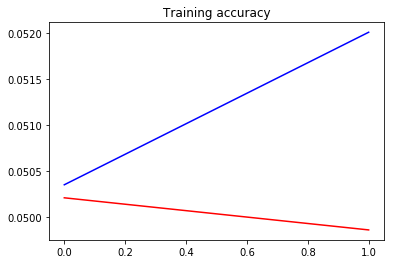

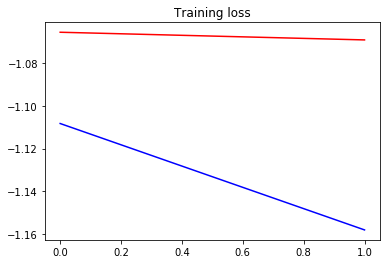

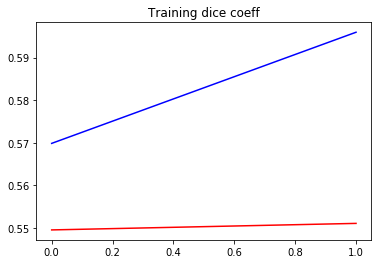

<Figure size 432x288 with 0 Axes>

In [31]:
# loss: -1.0319 - dice_coeff: 0.5650 - acc: 0.9551
# val_loss: -0.9757 - val_dice_coeff: 0.5386 - val_acc: 0.9611

def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    dice_coeff = history.history['dice_coeff']
    val_dice_coeff = history.history['val_dice_coeff']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b-')
    plt.plot(epochs, val_acc, 'r-')
    plt.title('Training accuracy')
    plt.figure()
    plt.plot(epochs, loss, 'b-')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training loss')
    plt.figure()
    plt.plot(epochs, dice_coeff, 'b-')
    plt.plot(epochs, val_dice_coeff, 'r-')
    plt.title('Training dice coeff')
    plt.figure()

    plt.show()
    
plot_training(history)

In [32]:
PATIENCE = 2
EPOCHS = 3

idx = int(0.80*len(df_train))
dataGen_train = ImgDataGenerator_V3_4(df_train.iloc[:idx], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE, 
                                    n_channels=3, n_classes=4, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5,
                                    shear_range=1, #OK
                                    zoom_range=[0.98,1.02], # OK
                                    rotation_range=1, #OK
                                    width_shift_range=0.01, height_shift_range=0.025,#OK
                                    horizontal_flip=True, vertical_flip=True, #OK
                                    shuffle=False)

dataGen_valid = ImgDataGenerator_V3_4(df_train.iloc[idx:], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE,
                                    n_channels=3, n_classes=4, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5,
                                    shuffle=False)

history = advanced_model.fit_generator(dataGen_train,
                              epochs=EPOCHS,    
                              validation_data=dataGen_valid,
                              verbose=1,
                              shuffle=True,
                              callbacks = get_callback(PATIENCE)
                             )

Epoch 1/3


132/946 [===>..........................] - ETA: 1:05:04 - loss: -1.1165 - dice_coeff: 0.5834 - acc: 0.06 - ETA: 39:53 - loss: -1.1933 - dice_coeff: 0.6145 - acc: 0.0501 - ETA: 35:53 - loss: -1.0607 - dice_coeff: 0.5470 - acc: 0.03 - ETA: 32:37 - loss: -1.1530 - dice_coeff: 0.5928 - acc: 0.05 - ETA: 32:39 - loss: -1.0343 - dice_coeff: 0.5347 - acc: 0.04 - ETA: 32:40 - loss: -1.0612 - dice_coeff: 0.5489 - acc: 0.05 - ETA: 32:47 - loss: -1.0251 - dice_coeff: 0.5308 - acc: 0.04 - ETA: 32:59 - loss: -1.0843 - dice_coeff: 0.5602 - acc: 0.05 - ETA: 33:07 - loss: -1.0566 - dice_coeff: 0.5454 - acc: 0.05 - ETA: 33:32 - loss: -1.0536 - dice_coeff: 0.5428 - acc: 0.04 - ETA: 32:46 - loss: -1.0110 - dice_coeff: 0.5214 - acc: 0.04 - ETA: 32:05 - loss: -1.0212 - dice_coeff: 0.5257 - acc: 0.04 - ETA: 31:34 - loss: -1.0416 - dice_coeff: 0.5365 - acc: 0.04 - ETA: 31:07 - loss: -1.0373 - dice_coeff: 0.5344 - acc: 0.04 - ETA: 30:44 - loss: -1.0461 - dice_coeff: 0.5387 - acc: 0.04 - ETA: 30:22 - loss: -1.0

264/946 [=======>......................] - ETA: 22:32 - loss: -1.1402 - dice_coeff: 0.5870 - acc: 0.05 - ETA: 22:30 - loss: -1.1417 - dice_coeff: 0.5878 - acc: 0.05 - ETA: 22:27 - loss: -1.1450 - dice_coeff: 0.5894 - acc: 0.05 - ETA: 22:25 - loss: -1.1455 - dice_coeff: 0.5899 - acc: 0.05 - ETA: 22:24 - loss: -1.1441 - dice_coeff: 0.5891 - acc: 0.05 - ETA: 22:23 - loss: -1.1446 - dice_coeff: 0.5894 - acc: 0.05 - ETA: 22:21 - loss: -1.1444 - dice_coeff: 0.5893 - acc: 0.05 - ETA: 22:19 - loss: -1.1445 - dice_coeff: 0.5893 - acc: 0.05 - ETA: 22:17 - loss: -1.1446 - dice_coeff: 0.5894 - acc: 0.05 - ETA: 22:14 - loss: -1.1461 - dice_coeff: 0.5902 - acc: 0.05 - ETA: 22:12 - loss: -1.1440 - dice_coeff: 0.5891 - acc: 0.05 - ETA: 22:10 - loss: -1.1450 - dice_coeff: 0.5895 - acc: 0.05 - ETA: 22:07 - loss: -1.1454 - dice_coeff: 0.5897 - acc: 0.05 - ETA: 22:05 - loss: -1.1476 - dice_coeff: 0.5907 - acc: 0.05 - ETA: 22:02 - loss: -1.1491 - dice_coeff: 0.5915 - acc: 0.05 - ETA: 22:01 - loss: -1.1496 

396/946 [===========>..................] - ETA: 18:09 - loss: -1.1665 - dice_coeff: 0.5996 - acc: 0.05 - ETA: 18:07 - loss: -1.1643 - dice_coeff: 0.5986 - acc: 0.05 - ETA: 18:05 - loss: -1.1651 - dice_coeff: 0.5990 - acc: 0.05 - ETA: 18:03 - loss: -1.1642 - dice_coeff: 0.5986 - acc: 0.05 - ETA: 18:02 - loss: -1.1647 - dice_coeff: 0.5988 - acc: 0.05 - ETA: 18:00 - loss: -1.1655 - dice_coeff: 0.5992 - acc: 0.05 - ETA: 17:58 - loss: -1.1650 - dice_coeff: 0.5989 - acc: 0.05 - ETA: 17:56 - loss: -1.1645 - dice_coeff: 0.5987 - acc: 0.05 - ETA: 17:55 - loss: -1.1646 - dice_coeff: 0.5988 - acc: 0.05 - ETA: 17:53 - loss: -1.1640 - dice_coeff: 0.5985 - acc: 0.05 - ETA: 17:51 - loss: -1.1639 - dice_coeff: 0.5984 - acc: 0.05 - ETA: 17:49 - loss: -1.1615 - dice_coeff: 0.5972 - acc: 0.05 - ETA: 17:48 - loss: -1.1616 - dice_coeff: 0.5974 - acc: 0.05 - ETA: 17:46 - loss: -1.1607 - dice_coeff: 0.5970 - acc: 0.05 - ETA: 17:44 - loss: -1.1615 - dice_coeff: 0.5973 - acc: 0.05 - ETA: 17:42 - loss: -1.1624 

528/946 [===============>..............] - ETA: 14:28 - loss: -1.1770 - dice_coeff: 0.6052 - acc: 0.05 - ETA: 14:27 - loss: -1.1768 - dice_coeff: 0.6051 - acc: 0.05 - ETA: 14:25 - loss: -1.1775 - dice_coeff: 0.6054 - acc: 0.05 - ETA: 14:23 - loss: -1.1784 - dice_coeff: 0.6058 - acc: 0.05 - ETA: 14:22 - loss: -1.1787 - dice_coeff: 0.6060 - acc: 0.05 - ETA: 14:20 - loss: -1.1793 - dice_coeff: 0.6063 - acc: 0.05 - ETA: 14:19 - loss: -1.1789 - dice_coeff: 0.6060 - acc: 0.05 - ETA: 14:17 - loss: -1.1787 - dice_coeff: 0.6059 - acc: 0.05 - ETA: 14:15 - loss: -1.1791 - dice_coeff: 0.6061 - acc: 0.05 - ETA: 14:14 - loss: -1.1777 - dice_coeff: 0.6054 - acc: 0.05 - ETA: 14:12 - loss: -1.1772 - dice_coeff: 0.6052 - acc: 0.05 - ETA: 14:10 - loss: -1.1765 - dice_coeff: 0.6049 - acc: 0.05 - ETA: 14:09 - loss: -1.1765 - dice_coeff: 0.6049 - acc: 0.05 - ETA: 14:07 - loss: -1.1770 - dice_coeff: 0.6052 - acc: 0.05 - ETA: 14:06 - loss: -1.1776 - dice_coeff: 0.6055 - acc: 0.05 - ETA: 14:04 - loss: -1.1773 

660/946 [===================>..........] - ETA: 10:57 - loss: -1.1765 - dice_coeff: 0.6048 - acc: 0.05 - ETA: 10:55 - loss: -1.1762 - dice_coeff: 0.6047 - acc: 0.05 - ETA: 10:53 - loss: -1.1751 - dice_coeff: 0.6042 - acc: 0.05 - ETA: 10:52 - loss: -1.1754 - dice_coeff: 0.6043 - acc: 0.05 - ETA: 10:50 - loss: -1.1754 - dice_coeff: 0.6043 - acc: 0.05 - ETA: 10:49 - loss: -1.1756 - dice_coeff: 0.6044 - acc: 0.05 - ETA: 10:47 - loss: -1.1757 - dice_coeff: 0.6044 - acc: 0.05 - ETA: 10:45 - loss: -1.1760 - dice_coeff: 0.6045 - acc: 0.05 - ETA: 10:44 - loss: -1.1760 - dice_coeff: 0.6045 - acc: 0.05 - ETA: 10:42 - loss: -1.1754 - dice_coeff: 0.6042 - acc: 0.05 - ETA: 10:41 - loss: -1.1755 - dice_coeff: 0.6043 - acc: 0.05 - ETA: 10:39 - loss: -1.1758 - dice_coeff: 0.6045 - acc: 0.05 - ETA: 10:37 - loss: -1.1754 - dice_coeff: 0.6043 - acc: 0.05 - ETA: 10:36 - loss: -1.1756 - dice_coeff: 0.6043 - acc: 0.05 - ETA: 10:34 - loss: -1.1753 - dice_coeff: 0.6042 - acc: 0.05 - ETA: 10:33 - loss: -1.1760 

792/946 [========================>.....] - ETA: 7:27 - loss: -1.1756 - dice_coeff: 0.6041 - acc: 0.053 - ETA: 7:26 - loss: -1.1756 - dice_coeff: 0.6041 - acc: 0.053 - ETA: 7:24 - loss: -1.1754 - dice_coeff: 0.6040 - acc: 0.053 - ETA: 7:23 - loss: -1.1756 - dice_coeff: 0.6041 - acc: 0.053 - ETA: 7:21 - loss: -1.1758 - dice_coeff: 0.6042 - acc: 0.052 - ETA: 7:19 - loss: -1.1760 - dice_coeff: 0.6043 - acc: 0.052 - ETA: 7:18 - loss: -1.1758 - dice_coeff: 0.6042 - acc: 0.052 - ETA: 7:16 - loss: -1.1757 - dice_coeff: 0.6041 - acc: 0.052 - ETA: 7:15 - loss: -1.1761 - dice_coeff: 0.6043 - acc: 0.052 - ETA: 7:13 - loss: -1.1766 - dice_coeff: 0.6046 - acc: 0.052 - ETA: 7:12 - loss: -1.1770 - dice_coeff: 0.6048 - acc: 0.053 - ETA: 7:10 - loss: -1.1772 - dice_coeff: 0.6049 - acc: 0.053 - ETA: 7:08 - loss: -1.1775 - dice_coeff: 0.6050 - acc: 0.052 - ETA: 7:07 - loss: -1.1782 - dice_coeff: 0.6053 - acc: 0.052 - ETA: 7:05 - loss: -1.1774 - dice_coeff: 0.6049 - acc: 0.052 - ETA: 7:04 - loss: -1.1774 -

924/946 [============================>.] - ETA: 3:59 - loss: -1.1752 - dice_coeff: 0.6040 - acc: 0.053 - ETA: 3:58 - loss: -1.1752 - dice_coeff: 0.6040 - acc: 0.053 - ETA: 3:56 - loss: -1.1751 - dice_coeff: 0.6039 - acc: 0.053 - ETA: 3:55 - loss: -1.1752 - dice_coeff: 0.6040 - acc: 0.053 - ETA: 3:53 - loss: -1.1752 - dice_coeff: 0.6040 - acc: 0.053 - ETA: 3:52 - loss: -1.1755 - dice_coeff: 0.6041 - acc: 0.053 - ETA: 3:50 - loss: -1.1750 - dice_coeff: 0.6039 - acc: 0.053 - ETA: 3:48 - loss: -1.1747 - dice_coeff: 0.6037 - acc: 0.053 - ETA: 3:47 - loss: -1.1750 - dice_coeff: 0.6039 - acc: 0.053 - ETA: 3:45 - loss: -1.1746 - dice_coeff: 0.6037 - acc: 0.053 - ETA: 3:44 - loss: -1.1748 - dice_coeff: 0.6038 - acc: 0.053 - ETA: 3:42 - loss: -1.1749 - dice_coeff: 0.6038 - acc: 0.053 - ETA: 3:41 - loss: -1.1752 - dice_coeff: 0.6040 - acc: 0.053 - ETA: 3:39 - loss: -1.1751 - dice_coeff: 0.6040 - acc: 0.053 - ETA: 3:37 - loss: -1.1751 - dice_coeff: 0.6039 - acc: 0.053 - ETA: 3:36 - loss: -1.1755 -

946/946 [==============================] - ETA: 32s - loss: -1.1714 - dice_coeff: 0.6023 - acc: 0.05 - ETA: 31s - loss: -1.1710 - dice_coeff: 0.6021 - acc: 0.05 - ETA: 29s - loss: -1.1705 - dice_coeff: 0.6019 - acc: 0.05 - ETA: 28s - loss: -1.1709 - dice_coeff: 0.6020 - acc: 0.05 - ETA: 26s - loss: -1.1711 - dice_coeff: 0.6021 - acc: 0.05 - ETA: 25s - loss: -1.1714 - dice_coeff: 0.6023 - acc: 0.05 - ETA: 23s - loss: -1.1711 - dice_coeff: 0.6022 - acc: 0.05 - ETA: 21s - loss: -1.1711 - dice_coeff: 0.6022 - acc: 0.05 - ETA: 20s - loss: -1.1713 - dice_coeff: 0.6023 - acc: 0.05 - ETA: 18s - loss: -1.1715 - dice_coeff: 0.6024 - acc: 0.05 - ETA: 17s - loss: -1.1718 - dice_coeff: 0.6025 - acc: 0.05 - ETA: 15s - loss: -1.1718 - dice_coeff: 0.6025 - acc: 0.05 - ETA: 14s - loss: -1.1714 - dice_coeff: 0.6023 - acc: 0.05 - ETA: 12s - loss: -1.1716 - dice_coeff: 0.6024 - acc: 0.05 - ETA: 10s - loss: -1.1709 - dice_coeff: 0.6021 - acc: 0.05 - ETA: 9s - loss: -1.1708 - dice_coeff: 0.6021 - acc: 0.053

132/946 [===>..........................] - ETA: 6:02 - loss: -0.5519 - dice_coeff: 0.3239 - acc: 0.067 - ETA: 6:02 - loss: -0.8987 - dice_coeff: 0.4770 - acc: 0.047 - ETA: 6:01 - loss: -0.8652 - dice_coeff: 0.4606 - acc: 0.050 - ETA: 6:01 - loss: -0.9368 - dice_coeff: 0.4920 - acc: 0.044 - ETA: 6:00 - loss: -1.0271 - dice_coeff: 0.5378 - acc: 0.062 - ETA: 6:00 - loss: -1.0464 - dice_coeff: 0.5462 - acc: 0.059 - ETA: 6:01 - loss: -1.0975 - dice_coeff: 0.5713 - acc: 0.066 - ETA: 6:01 - loss: -1.0549 - dice_coeff: 0.5492 - acc: 0.061 - ETA: 6:00 - loss: -1.0453 - dice_coeff: 0.5452 - acc: 0.061 - ETA: 5:58 - loss: -1.0462 - dice_coeff: 0.5445 - acc: 0.057 - ETA: 5:58 - loss: -1.0705 - dice_coeff: 0.5567 - acc: 0.061 - ETA: 5:58 - loss: -1.0727 - dice_coeff: 0.5590 - acc: 0.064 - ETA: 5:59 - loss: -1.0882 - dice_coeff: 0.5663 - acc: 0.063 - ETA: 8:04 - loss: -1.0604 - dice_coeff: 0.5539 - acc: 0.063 - ETA: 9:52 - loss: -1.0580 - dice_coeff: 0.5526 - acc: 0.063 - ETA: 11:25 - loss: -1.0386 

264/946 [=======>......................] - ETA: 20:08 - loss: -1.1936 - dice_coeff: 0.6139 - acc: 0.05 - ETA: 20:07 - loss: -1.1954 - dice_coeff: 0.6147 - acc: 0.05 - ETA: 20:06 - loss: -1.1963 - dice_coeff: 0.6153 - acc: 0.05 - ETA: 20:05 - loss: -1.1981 - dice_coeff: 0.6161 - acc: 0.05 - ETA: 20:04 - loss: -1.1963 - dice_coeff: 0.6152 - acc: 0.05 - ETA: 20:02 - loss: -1.1925 - dice_coeff: 0.6135 - acc: 0.05 - ETA: 20:01 - loss: -1.1918 - dice_coeff: 0.6131 - acc: 0.05 - ETA: 20:01 - loss: -1.1909 - dice_coeff: 0.6126 - acc: 0.05 - ETA: 20:00 - loss: -1.1910 - dice_coeff: 0.6127 - acc: 0.05 - ETA: 20:00 - loss: -1.1908 - dice_coeff: 0.6125 - acc: 0.05 - ETA: 20:00 - loss: -1.1907 - dice_coeff: 0.6127 - acc: 0.05 - ETA: 19:59 - loss: -1.1895 - dice_coeff: 0.6121 - acc: 0.05 - ETA: 19:58 - loss: -1.1915 - dice_coeff: 0.6131 - acc: 0.05 - ETA: 19:57 - loss: -1.1901 - dice_coeff: 0.6123 - acc: 0.05 - ETA: 19:56 - loss: -1.1906 - dice_coeff: 0.6126 - acc: 0.05 - ETA: 19:54 - loss: -1.1919 

396/946 [===========>..................] - ETA: 17:20 - loss: -1.1756 - dice_coeff: 0.6047 - acc: 0.05 - ETA: 17:18 - loss: -1.1748 - dice_coeff: 0.6043 - acc: 0.05 - ETA: 17:17 - loss: -1.1751 - dice_coeff: 0.6044 - acc: 0.05 - ETA: 17:15 - loss: -1.1767 - dice_coeff: 0.6052 - acc: 0.05 - ETA: 17:14 - loss: -1.1773 - dice_coeff: 0.6055 - acc: 0.05 - ETA: 17:12 - loss: -1.1777 - dice_coeff: 0.6056 - acc: 0.05 - ETA: 17:11 - loss: -1.1791 - dice_coeff: 0.6063 - acc: 0.05 - ETA: 17:10 - loss: -1.1809 - dice_coeff: 0.6072 - acc: 0.05 - ETA: 17:08 - loss: -1.1820 - dice_coeff: 0.6077 - acc: 0.05 - ETA: 17:07 - loss: -1.1827 - dice_coeff: 0.6080 - acc: 0.05 - ETA: 17:05 - loss: -1.1839 - dice_coeff: 0.6087 - acc: 0.05 - ETA: 17:04 - loss: -1.1844 - dice_coeff: 0.6089 - acc: 0.05 - ETA: 17:02 - loss: -1.1842 - dice_coeff: 0.6088 - acc: 0.05 - ETA: 17:01 - loss: -1.1833 - dice_coeff: 0.6085 - acc: 0.05 - ETA: 17:00 - loss: -1.1835 - dice_coeff: 0.6086 - acc: 0.05 - ETA: 16:58 - loss: -1.1804 

528/946 [===============>..............] - ETA: 14:06 - loss: -1.1780 - dice_coeff: 0.6059 - acc: 0.05 - ETA: 14:04 - loss: -1.1780 - dice_coeff: 0.6059 - acc: 0.05 - ETA: 14:03 - loss: -1.1780 - dice_coeff: 0.6059 - acc: 0.05 - ETA: 14:01 - loss: -1.1772 - dice_coeff: 0.6055 - acc: 0.05 - ETA: 14:00 - loss: -1.1771 - dice_coeff: 0.6055 - acc: 0.05 - ETA: 13:58 - loss: -1.1779 - dice_coeff: 0.6059 - acc: 0.05 - ETA: 13:57 - loss: -1.1782 - dice_coeff: 0.6060 - acc: 0.05 - ETA: 13:55 - loss: -1.1788 - dice_coeff: 0.6063 - acc: 0.05 - ETA: 13:54 - loss: -1.1786 - dice_coeff: 0.6062 - acc: 0.05 - ETA: 13:52 - loss: -1.1790 - dice_coeff: 0.6064 - acc: 0.05 - ETA: 13:51 - loss: -1.1793 - dice_coeff: 0.6066 - acc: 0.05 - ETA: 13:49 - loss: -1.1779 - dice_coeff: 0.6059 - acc: 0.05 - ETA: 13:48 - loss: -1.1786 - dice_coeff: 0.6062 - acc: 0.05 - ETA: 13:46 - loss: -1.1784 - dice_coeff: 0.6061 - acc: 0.05 - ETA: 13:45 - loss: -1.1796 - dice_coeff: 0.6067 - acc: 0.05 - ETA: 13:43 - loss: -1.1800 

660/946 [===================>..........] - ETA: 10:46 - loss: -1.1833 - dice_coeff: 0.6081 - acc: 0.05 - ETA: 10:44 - loss: -1.1835 - dice_coeff: 0.6082 - acc: 0.05 - ETA: 10:43 - loss: -1.1826 - dice_coeff: 0.6077 - acc: 0.05 - ETA: 10:41 - loss: -1.1824 - dice_coeff: 0.6076 - acc: 0.05 - ETA: 10:40 - loss: -1.1824 - dice_coeff: 0.6076 - acc: 0.05 - ETA: 10:38 - loss: -1.1823 - dice_coeff: 0.6075 - acc: 0.05 - ETA: 10:36 - loss: -1.1823 - dice_coeff: 0.6075 - acc: 0.05 - ETA: 10:35 - loss: -1.1823 - dice_coeff: 0.6075 - acc: 0.05 - ETA: 10:33 - loss: -1.1826 - dice_coeff: 0.6077 - acc: 0.05 - ETA: 10:32 - loss: -1.1828 - dice_coeff: 0.6078 - acc: 0.05 - ETA: 10:30 - loss: -1.1825 - dice_coeff: 0.6076 - acc: 0.05 - ETA: 10:29 - loss: -1.1826 - dice_coeff: 0.6077 - acc: 0.05 - ETA: 10:27 - loss: -1.1826 - dice_coeff: 0.6077 - acc: 0.05 - ETA: 10:26 - loss: -1.1823 - dice_coeff: 0.6075 - acc: 0.05 - ETA: 10:24 - loss: -1.1827 - dice_coeff: 0.6077 - acc: 0.05 - ETA: 10:23 - loss: -1.1826 

792/946 [========================>.....] - ETA: 7:23 - loss: -1.1789 - dice_coeff: 0.6058 - acc: 0.055 - ETA: 7:21 - loss: -1.1790 - dice_coeff: 0.6058 - acc: 0.055 - ETA: 7:19 - loss: -1.1794 - dice_coeff: 0.6060 - acc: 0.055 - ETA: 7:18 - loss: -1.1799 - dice_coeff: 0.6063 - acc: 0.055 - ETA: 7:16 - loss: -1.1801 - dice_coeff: 0.6064 - acc: 0.054 - ETA: 7:15 - loss: -1.1805 - dice_coeff: 0.6065 - acc: 0.054 - ETA: 7:13 - loss: -1.1802 - dice_coeff: 0.6064 - acc: 0.054 - ETA: 7:12 - loss: -1.1799 - dice_coeff: 0.6063 - acc: 0.054 - ETA: 7:10 - loss: -1.1793 - dice_coeff: 0.6059 - acc: 0.054 - ETA: 7:08 - loss: -1.1793 - dice_coeff: 0.6059 - acc: 0.054 - ETA: 7:07 - loss: -1.1782 - dice_coeff: 0.6055 - acc: 0.054 - ETA: 7:05 - loss: -1.1783 - dice_coeff: 0.6055 - acc: 0.054 - ETA: 7:04 - loss: -1.1787 - dice_coeff: 0.6057 - acc: 0.054 - ETA: 7:02 - loss: -1.1789 - dice_coeff: 0.6058 - acc: 0.054 - ETA: 7:01 - loss: -1.1793 - dice_coeff: 0.6059 - acc: 0.054 - ETA: 6:59 - loss: -1.1797 -

924/946 [============================>.] - ETA: 3:58 - loss: -1.1771 - dice_coeff: 0.6049 - acc: 0.054 - ETA: 3:56 - loss: -1.1769 - dice_coeff: 0.6048 - acc: 0.054 - ETA: 3:55 - loss: -1.1771 - dice_coeff: 0.6049 - acc: 0.054 - ETA: 3:53 - loss: -1.1772 - dice_coeff: 0.6050 - acc: 0.054 - ETA: 3:52 - loss: -1.1775 - dice_coeff: 0.6051 - acc: 0.054 - ETA: 3:50 - loss: -1.1776 - dice_coeff: 0.6051 - acc: 0.054 - ETA: 3:49 - loss: -1.1775 - dice_coeff: 0.6051 - acc: 0.054 - ETA: 3:47 - loss: -1.1779 - dice_coeff: 0.6052 - acc: 0.054 - ETA: 3:45 - loss: -1.1775 - dice_coeff: 0.6051 - acc: 0.054 - ETA: 3:44 - loss: -1.1773 - dice_coeff: 0.6050 - acc: 0.054 - ETA: 3:42 - loss: -1.1771 - dice_coeff: 0.6049 - acc: 0.054 - ETA: 3:41 - loss: -1.1772 - dice_coeff: 0.6049 - acc: 0.054 - ETA: 3:39 - loss: -1.1776 - dice_coeff: 0.6051 - acc: 0.054 - ETA: 3:38 - loss: -1.1778 - dice_coeff: 0.6052 - acc: 0.054 - ETA: 3:36 - loss: -1.1781 - dice_coeff: 0.6053 - acc: 0.054 - ETA: 3:35 - loss: -1.1777 -

946/946 [==============================] - ETA: 32s - loss: -1.1794 - dice_coeff: 0.6061 - acc: 0.05 - ETA: 31s - loss: -1.1797 - dice_coeff: 0.6062 - acc: 0.05 - ETA: 29s - loss: -1.1800 - dice_coeff: 0.6064 - acc: 0.05 - ETA: 28s - loss: -1.1798 - dice_coeff: 0.6063 - acc: 0.05 - ETA: 26s - loss: -1.1799 - dice_coeff: 0.6063 - acc: 0.05 - ETA: 24s - loss: -1.1800 - dice_coeff: 0.6064 - acc: 0.05 - ETA: 23s - loss: -1.1804 - dice_coeff: 0.6066 - acc: 0.05 - ETA: 21s - loss: -1.1798 - dice_coeff: 0.6063 - acc: 0.05 - ETA: 20s - loss: -1.1799 - dice_coeff: 0.6063 - acc: 0.05 - ETA: 18s - loss: -1.1797 - dice_coeff: 0.6062 - acc: 0.05 - ETA: 17s - loss: -1.1799 - dice_coeff: 0.6063 - acc: 0.05 - ETA: 15s - loss: -1.1800 - dice_coeff: 0.6064 - acc: 0.05 - ETA: 14s - loss: -1.1800 - dice_coeff: 0.6064 - acc: 0.05 - ETA: 12s - loss: -1.1802 - dice_coeff: 0.6065 - acc: 0.05 - ETA: 10s - loss: -1.1799 - dice_coeff: 0.6063 - acc: 0.05 - ETA: 9s - loss: -1.1797 - dice_coeff: 0.6062 - acc: 0.055

132/946 [===>..........................] - ETA: 5:57 - loss: -0.9167 - dice_coeff: 0.4873 - acc: 0.053 - ETA: 6:05 - loss: -1.1945 - dice_coeff: 0.6186 - acc: 0.078 - ETA: 5:59 - loss: -1.1570 - dice_coeff: 0.6032 - acc: 0.087 - ETA: 5:59 - loss: -1.1673 - dice_coeff: 0.6053 - acc: 0.074 - ETA: 5:59 - loss: -1.1269 - dice_coeff: 0.5893 - acc: 0.078 - ETA: 5:59 - loss: -0.9821 - dice_coeff: 0.5219 - acc: 0.072 - ETA: 5:57 - loss: -1.0075 - dice_coeff: 0.5320 - acc: 0.069 - ETA: 5:58 - loss: -1.0374 - dice_coeff: 0.5449 - acc: 0.066 - ETA: 5:58 - loss: -1.0658 - dice_coeff: 0.5571 - acc: 0.062 - ETA: 5:58 - loss: -1.0648 - dice_coeff: 0.5557 - acc: 0.060 - ETA: 5:57 - loss: -1.1097 - dice_coeff: 0.5775 - acc: 0.070 - ETA: 5:57 - loss: -1.1246 - dice_coeff: 0.5846 - acc: 0.068 - ETA: 5:58 - loss: -1.0801 - dice_coeff: 0.5627 - acc: 0.066 - ETA: 7:57 - loss: -1.0397 - dice_coeff: 0.5449 - acc: 0.067 - ETA: 9:42 - loss: -1.0089 - dice_coeff: 0.5292 - acc: 0.064 - ETA: 11:13 - loss: -1.0074 

264/946 [=======>......................] - ETA: 20:06 - loss: -1.1750 - dice_coeff: 0.6042 - acc: 0.05 - ETA: 20:05 - loss: -1.1761 - dice_coeff: 0.6047 - acc: 0.05 - ETA: 20:04 - loss: -1.1755 - dice_coeff: 0.6045 - acc: 0.05 - ETA: 20:03 - loss: -1.1742 - dice_coeff: 0.6039 - acc: 0.05 - ETA: 20:03 - loss: -1.1773 - dice_coeff: 0.6054 - acc: 0.05 - ETA: 20:01 - loss: -1.1765 - dice_coeff: 0.6050 - acc: 0.05 - ETA: 20:00 - loss: -1.1791 - dice_coeff: 0.6062 - acc: 0.05 - ETA: 19:59 - loss: -1.1755 - dice_coeff: 0.6045 - acc: 0.05 - ETA: 19:58 - loss: -1.1749 - dice_coeff: 0.6042 - acc: 0.05 - ETA: 19:57 - loss: -1.1745 - dice_coeff: 0.6040 - acc: 0.05 - ETA: 19:56 - loss: -1.1719 - dice_coeff: 0.6028 - acc: 0.05 - ETA: 19:55 - loss: -1.1690 - dice_coeff: 0.6015 - acc: 0.05 - ETA: 19:54 - loss: -1.1715 - dice_coeff: 0.6027 - acc: 0.05 - ETA: 19:53 - loss: -1.1742 - dice_coeff: 0.6040 - acc: 0.05 - ETA: 19:52 - loss: -1.1741 - dice_coeff: 0.6039 - acc: 0.05 - ETA: 19:51 - loss: -1.1769 

396/946 [===========>..................] - ETA: 17:21 - loss: -1.1951 - dice_coeff: 0.6134 - acc: 0.05 - ETA: 17:19 - loss: -1.1950 - dice_coeff: 0.6133 - acc: 0.05 - ETA: 17:18 - loss: -1.1951 - dice_coeff: 0.6133 - acc: 0.05 - ETA: 17:16 - loss: -1.1955 - dice_coeff: 0.6135 - acc: 0.05 - ETA: 17:15 - loss: -1.1957 - dice_coeff: 0.6136 - acc: 0.05 - ETA: 17:14 - loss: -1.1950 - dice_coeff: 0.6132 - acc: 0.05 - ETA: 17:12 - loss: -1.1958 - dice_coeff: 0.6136 - acc: 0.05 - ETA: 17:11 - loss: -1.1966 - dice_coeff: 0.6141 - acc: 0.05 - ETA: 17:09 - loss: -1.1946 - dice_coeff: 0.6131 - acc: 0.05 - ETA: 17:08 - loss: -1.1952 - dice_coeff: 0.6135 - acc: 0.05 - ETA: 17:06 - loss: -1.1956 - dice_coeff: 0.6136 - acc: 0.05 - ETA: 17:05 - loss: -1.1969 - dice_coeff: 0.6143 - acc: 0.05 - ETA: 17:03 - loss: -1.1960 - dice_coeff: 0.6139 - acc: 0.05 - ETA: 17:02 - loss: -1.1971 - dice_coeff: 0.6145 - acc: 0.05 - ETA: 17:00 - loss: -1.1970 - dice_coeff: 0.6144 - acc: 0.05 - ETA: 16:59 - loss: -1.1963 

528/946 [===============>..............] - ETA: 14:06 - loss: -1.1924 - dice_coeff: 0.6122 - acc: 0.05 - ETA: 14:05 - loss: -1.1934 - dice_coeff: 0.6126 - acc: 0.05 - ETA: 14:03 - loss: -1.1928 - dice_coeff: 0.6123 - acc: 0.05 - ETA: 14:02 - loss: -1.1925 - dice_coeff: 0.6122 - acc: 0.05 - ETA: 14:00 - loss: -1.1928 - dice_coeff: 0.6123 - acc: 0.05 - ETA: 13:59 - loss: -1.1934 - dice_coeff: 0.6126 - acc: 0.05 - ETA: 13:57 - loss: -1.1935 - dice_coeff: 0.6126 - acc: 0.05 - ETA: 13:56 - loss: -1.1931 - dice_coeff: 0.6124 - acc: 0.05 - ETA: 13:54 - loss: -1.1933 - dice_coeff: 0.6125 - acc: 0.05 - ETA: 13:53 - loss: -1.1937 - dice_coeff: 0.6128 - acc: 0.05 - ETA: 13:51 - loss: -1.1927 - dice_coeff: 0.6123 - acc: 0.05 - ETA: 13:50 - loss: -1.1925 - dice_coeff: 0.6121 - acc: 0.05 - ETA: 13:48 - loss: -1.1918 - dice_coeff: 0.6119 - acc: 0.05 - ETA: 13:47 - loss: -1.1916 - dice_coeff: 0.6118 - acc: 0.05 - ETA: 13:46 - loss: -1.1921 - dice_coeff: 0.6120 - acc: 0.05 - ETA: 13:44 - loss: -1.1926 

660/946 [===================>..........] - ETA: 10:46 - loss: -1.1981 - dice_coeff: 0.6150 - acc: 0.05 - ETA: 10:44 - loss: -1.1983 - dice_coeff: 0.6151 - acc: 0.05 - ETA: 10:43 - loss: -1.1981 - dice_coeff: 0.6150 - acc: 0.05 - ETA: 10:41 - loss: -1.1971 - dice_coeff: 0.6145 - acc: 0.05 - ETA: 10:40 - loss: -1.1968 - dice_coeff: 0.6144 - acc: 0.05 - ETA: 10:38 - loss: -1.1967 - dice_coeff: 0.6144 - acc: 0.05 - ETA: 10:37 - loss: -1.1963 - dice_coeff: 0.6142 - acc: 0.05 - ETA: 10:35 - loss: -1.1959 - dice_coeff: 0.6140 - acc: 0.05 - ETA: 10:34 - loss: -1.1959 - dice_coeff: 0.6141 - acc: 0.05 - ETA: 10:32 - loss: -1.1962 - dice_coeff: 0.6142 - acc: 0.05 - ETA: 10:31 - loss: -1.1961 - dice_coeff: 0.6141 - acc: 0.05 - ETA: 10:29 - loss: -1.1964 - dice_coeff: 0.6142 - acc: 0.05 - ETA: 10:28 - loss: -1.1969 - dice_coeff: 0.6145 - acc: 0.05 - ETA: 10:26 - loss: -1.1960 - dice_coeff: 0.6141 - acc: 0.05 - ETA: 10:25 - loss: -1.1959 - dice_coeff: 0.6140 - acc: 0.05 - ETA: 10:23 - loss: -1.1961 

792/946 [========================>.....] - ETA: 7:23 - loss: -1.1844 - dice_coeff: 0.6084 - acc: 0.057 - ETA: 7:21 - loss: -1.1846 - dice_coeff: 0.6085 - acc: 0.057 - ETA: 7:20 - loss: -1.1844 - dice_coeff: 0.6085 - acc: 0.057 - ETA: 7:18 - loss: -1.1836 - dice_coeff: 0.6081 - acc: 0.057 - ETA: 7:17 - loss: -1.1834 - dice_coeff: 0.6080 - acc: 0.057 - ETA: 7:15 - loss: -1.1831 - dice_coeff: 0.6079 - acc: 0.057 - ETA: 7:14 - loss: -1.1833 - dice_coeff: 0.6080 - acc: 0.057 - ETA: 7:12 - loss: -1.1837 - dice_coeff: 0.6082 - acc: 0.057 - ETA: 7:10 - loss: -1.1841 - dice_coeff: 0.6083 - acc: 0.057 - ETA: 7:09 - loss: -1.1844 - dice_coeff: 0.6085 - acc: 0.057 - ETA: 7:07 - loss: -1.1841 - dice_coeff: 0.6083 - acc: 0.057 - ETA: 7:06 - loss: -1.1844 - dice_coeff: 0.6085 - acc: 0.057 - ETA: 7:04 - loss: -1.1847 - dice_coeff: 0.6086 - acc: 0.057 - ETA: 7:03 - loss: -1.1850 - dice_coeff: 0.6088 - acc: 0.057 - ETA: 7:01 - loss: -1.1847 - dice_coeff: 0.6086 - acc: 0.057 - ETA: 7:00 - loss: -1.1848 -

924/946 [============================>.] - ETA: 3:58 - loss: -1.1858 - dice_coeff: 0.6091 - acc: 0.057 - ETA: 3:56 - loss: -1.1860 - dice_coeff: 0.6092 - acc: 0.057 - ETA: 3:55 - loss: -1.1858 - dice_coeff: 0.6091 - acc: 0.057 - ETA: 3:53 - loss: -1.1854 - dice_coeff: 0.6089 - acc: 0.057 - ETA: 3:52 - loss: -1.1854 - dice_coeff: 0.6089 - acc: 0.057 - ETA: 3:50 - loss: -1.1858 - dice_coeff: 0.6091 - acc: 0.057 - ETA: 3:49 - loss: -1.1862 - dice_coeff: 0.6093 - acc: 0.057 - ETA: 3:47 - loss: -1.1863 - dice_coeff: 0.6093 - acc: 0.057 - ETA: 3:46 - loss: -1.1861 - dice_coeff: 0.6092 - acc: 0.057 - ETA: 3:44 - loss: -1.1862 - dice_coeff: 0.6093 - acc: 0.057 - ETA: 3:42 - loss: -1.1856 - dice_coeff: 0.6090 - acc: 0.057 - ETA: 3:41 - loss: -1.1855 - dice_coeff: 0.6089 - acc: 0.057 - ETA: 3:39 - loss: -1.1852 - dice_coeff: 0.6088 - acc: 0.057 - ETA: 3:38 - loss: -1.1856 - dice_coeff: 0.6090 - acc: 0.057 - ETA: 3:36 - loss: -1.1859 - dice_coeff: 0.6091 - acc: 0.057 - ETA: 3:35 - loss: -1.1860 -

946/946 [==============================] - ETA: 32s - loss: -1.1875 - dice_coeff: 0.6099 - acc: 0.05 - ETA: 31s - loss: -1.1870 - dice_coeff: 0.6096 - acc: 0.05 - ETA: 29s - loss: -1.1874 - dice_coeff: 0.6098 - acc: 0.05 - ETA: 28s - loss: -1.1876 - dice_coeff: 0.6099 - acc: 0.05 - ETA: 26s - loss: -1.1879 - dice_coeff: 0.6101 - acc: 0.05 - ETA: 24s - loss: -1.1877 - dice_coeff: 0.6100 - acc: 0.05 - ETA: 23s - loss: -1.1878 - dice_coeff: 0.6100 - acc: 0.05 - ETA: 21s - loss: -1.1875 - dice_coeff: 0.6099 - acc: 0.05 - ETA: 20s - loss: -1.1877 - dice_coeff: 0.6099 - acc: 0.05 - ETA: 18s - loss: -1.1881 - dice_coeff: 0.6101 - acc: 0.05 - ETA: 17s - loss: -1.1884 - dice_coeff: 0.6103 - acc: 0.05 - ETA: 15s - loss: -1.1884 - dice_coeff: 0.6103 - acc: 0.05 - ETA: 14s - loss: -1.1882 - dice_coeff: 0.6102 - acc: 0.05 - ETA: 12s - loss: -1.1885 - dice_coeff: 0.6104 - acc: 0.05 - ETA: 10s - loss: -1.1888 - dice_coeff: 0.6105 - acc: 0.05 - ETA: 9s - loss: -1.1890 - dice_coeff: 0.6106 - acc: 0.058

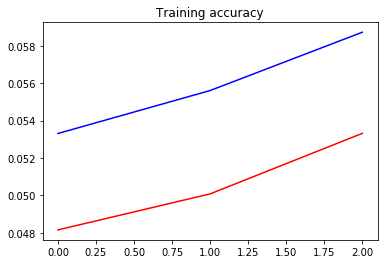

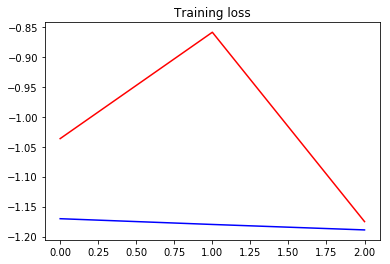

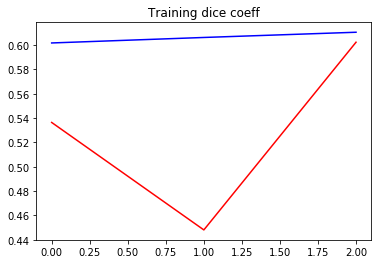

<Figure size 432x288 with 0 Axes>

In [33]:
plot_training(history)

#### Are the lower layers still not trainable?

In [34]:
layer = advanced_model.get_layer(index=11)
print(layer.get_config())

layer_128x800_initially = layer.get_weights()[0][2][2][15]
print(layer_128x800_initially)

{'name': 'conv2d_4', 'trainable': False, 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
[ 0.08418728  0.00819419 -0.06599229  0.07008211  0.12476645  0.03183701
  0.00329437 -0.01555774 -0.01261162 -0.06082976  0.06055311 -0.06053708
 -0.0125707  -0.02690234 -0.09208127 -0.02595484 -0.01815376 -0.05584485
  0.08554833  0.03638221  0.06536117 -0.09692373 -0.08140451  0.05165739
 -0.00049532  0.00487578 -0.08669613  0.05653386 -0.05016568  0.05280377
  0.09313481  0.05437035]


<p><BR>
    <b> So the layer is not trainable however the weights have changed slightly!<BR><BR> 
    TODO: Understand why weights have changed slightly
</p>
 
#### Lets make the layers trainable

In [35]:
# Takes roughly a minute
for idx in range(4, 96):
    layer_128x800 = advanced_model.get_layer(index=(idx + 7))
    layer_128x800.trainable=True

In [38]:
layer = advanced_model.get_layer(index=11)
print(layer.get_config())

{'name': 'conv2d_4', 'trainable': True, 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}


In [39]:
advanced_model.compile(optimizer=RMSprop(lr=0.0003), loss=bce_dice_loss, metrics=[dice_coeff, 'accuracy'])

In [40]:
PATIENCE = 2
EPOCHS = 3

idx = int(0.80*len(df_train))
dataGen_train = ImgDataGenerator_V3_4(df_train.iloc[:idx], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE, 
                                    n_channels=3, n_classes=4, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5,
                                    shear_range=1, #OK
                                    zoom_range=[0.98,1.02], # OK
                                    rotation_range=1, #OK
                                    width_shift_range=0.01, height_shift_range=0.025,#OK
                                    horizontal_flip=True, vertical_flip=True, #OK
                                    shuffle=False)

dataGen_valid = ImgDataGenerator_V3_4(df_train.iloc[idx:], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE,
                                    n_channels=3, n_classes=4, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5,
                                    shuffle=False)

history = advanced_model.fit_generator(dataGen_train,
                              epochs=EPOCHS,    
                              validation_data=dataGen_valid,
                              verbose=1,
                              shuffle=True,
                              callbacks = get_callback(PATIENCE)
                             )

Epoch 1/3


132/946 [===>..........................] - ETA: 4:40:39 - loss: -0.4885 - dice_coeff: 0.2701 - acc: 0.02 - ETA: 2:23:48 - loss: -0.5448 - dice_coeff: 0.3031 - acc: 0.05 - ETA: 1:38:12 - loss: -0.5854 - dice_coeff: 0.3212 - acc: 0.05 - ETA: 1:15:24 - loss: -0.5656 - dice_coeff: 0.3085 - acc: 0.04 - ETA: 1:01:43 - loss: -0.7118 - dice_coeff: 0.3807 - acc: 0.05 - ETA: 52:33 - loss: -0.7326 - dice_coeff: 0.3917 - acc: 0.0523 - ETA: 46:02 - loss: -0.8093 - dice_coeff: 0.4281 - acc: 0.05 - ETA: 41:09 - loss: -0.8531 - dice_coeff: 0.4489 - acc: 0.05 - ETA: 37:19 - loss: -0.8495 - dice_coeff: 0.4464 - acc: 0.05 - ETA: 34:17 - loss: -0.8659 - dice_coeff: 0.4533 - acc: 0.05 - ETA: 33:15 - loss: -0.9061 - dice_coeff: 0.4729 - acc: 0.05 - ETA: 32:31 - loss: -0.9388 - dice_coeff: 0.4883 - acc: 0.05 - ETA: 32:00 - loss: -0.9811 - dice_coeff: 0.5088 - acc: 0.05 - ETA: 31:27 - loss: -0.9732 - dice_coeff: 0.5048 - acc: 0.05 - ETA: 30:57 - loss: -0.9780 - dice_coeff: 0.5085 - acc: 0.05 - ETA: 30:36 - lo

264/946 [=======>......................] - ETA: 22:28 - loss: -1.0976 - dice_coeff: 0.5684 - acc: 0.06 - ETA: 22:26 - loss: -1.0969 - dice_coeff: 0.5680 - acc: 0.06 - ETA: 22:23 - loss: -1.0999 - dice_coeff: 0.5694 - acc: 0.06 - ETA: 22:21 - loss: -1.0959 - dice_coeff: 0.5675 - acc: 0.06 - ETA: 22:18 - loss: -1.0976 - dice_coeff: 0.5684 - acc: 0.06 - ETA: 22:17 - loss: -1.0985 - dice_coeff: 0.5688 - acc: 0.06 - ETA: 22:15 - loss: -1.1011 - dice_coeff: 0.5700 - acc: 0.06 - ETA: 22:13 - loss: -1.1024 - dice_coeff: 0.5705 - acc: 0.06 - ETA: 22:11 - loss: -1.1047 - dice_coeff: 0.5716 - acc: 0.06 - ETA: 22:10 - loss: -1.1066 - dice_coeff: 0.5725 - acc: 0.06 - ETA: 22:08 - loss: -1.1062 - dice_coeff: 0.5723 - acc: 0.06 - ETA: 22:06 - loss: -1.1068 - dice_coeff: 0.5726 - acc: 0.06 - ETA: 22:05 - loss: -1.1081 - dice_coeff: 0.5732 - acc: 0.06 - ETA: 22:03 - loss: -1.1094 - dice_coeff: 0.5738 - acc: 0.06 - ETA: 22:02 - loss: -1.1121 - dice_coeff: 0.5750 - acc: 0.06 - ETA: 22:00 - loss: -1.1109 

396/946 [===========>..................] - ETA: 18:39 - loss: -1.1001 - dice_coeff: 0.5692 - acc: 0.06 - ETA: 18:37 - loss: -1.1013 - dice_coeff: 0.5698 - acc: 0.06 - ETA: 18:36 - loss: -1.1006 - dice_coeff: 0.5694 - acc: 0.06 - ETA: 18:34 - loss: -1.1000 - dice_coeff: 0.5691 - acc: 0.06 - ETA: 18:33 - loss: -1.0995 - dice_coeff: 0.5688 - acc: 0.06 - ETA: 18:31 - loss: -1.0982 - dice_coeff: 0.5682 - acc: 0.06 - ETA: 18:29 - loss: -1.0983 - dice_coeff: 0.5682 - acc: 0.06 - ETA: 18:28 - loss: -1.0986 - dice_coeff: 0.5683 - acc: 0.06 - ETA: 18:26 - loss: -1.0993 - dice_coeff: 0.5687 - acc: 0.06 - ETA: 18:24 - loss: -1.0960 - dice_coeff: 0.5671 - acc: 0.06 - ETA: 18:23 - loss: -1.0949 - dice_coeff: 0.5666 - acc: 0.06 - ETA: 18:21 - loss: -1.0953 - dice_coeff: 0.5668 - acc: 0.06 - ETA: 18:19 - loss: -1.0957 - dice_coeff: 0.5670 - acc: 0.06 - ETA: 18:17 - loss: -1.0955 - dice_coeff: 0.5669 - acc: 0.06 - ETA: 18:16 - loss: -1.0953 - dice_coeff: 0.5668 - acc: 0.06 - ETA: 18:14 - loss: -1.0957 

528/946 [===============>..............] - ETA: 14:58 - loss: -1.1073 - dice_coeff: 0.5725 - acc: 0.06 - ETA: 14:56 - loss: -1.1073 - dice_coeff: 0.5725 - acc: 0.06 - ETA: 14:55 - loss: -1.1069 - dice_coeff: 0.5722 - acc: 0.06 - ETA: 14:53 - loss: -1.1079 - dice_coeff: 0.5727 - acc: 0.06 - ETA: 14:51 - loss: -1.1073 - dice_coeff: 0.5724 - acc: 0.06 - ETA: 14:49 - loss: -1.1084 - dice_coeff: 0.5729 - acc: 0.06 - ETA: 14:48 - loss: -1.1087 - dice_coeff: 0.5731 - acc: 0.06 - ETA: 14:46 - loss: -1.1094 - dice_coeff: 0.5734 - acc: 0.06 - ETA: 14:44 - loss: -1.1094 - dice_coeff: 0.5734 - acc: 0.06 - ETA: 14:43 - loss: -1.1098 - dice_coeff: 0.5735 - acc: 0.06 - ETA: 14:41 - loss: -1.1102 - dice_coeff: 0.5738 - acc: 0.06 - ETA: 14:39 - loss: -1.1109 - dice_coeff: 0.5741 - acc: 0.06 - ETA: 14:38 - loss: -1.1113 - dice_coeff: 0.5743 - acc: 0.06 - ETA: 14:36 - loss: -1.1114 - dice_coeff: 0.5743 - acc: 0.06 - ETA: 14:34 - loss: -1.1119 - dice_coeff: 0.5745 - acc: 0.06 - ETA: 14:33 - loss: -1.1109 

660/946 [===================>..........] - ETA: 11:20 - loss: -1.1004 - dice_coeff: 0.5691 - acc: 0.06 - ETA: 11:18 - loss: -1.0997 - dice_coeff: 0.5688 - acc: 0.06 - ETA: 11:17 - loss: -1.0999 - dice_coeff: 0.5689 - acc: 0.06 - ETA: 11:15 - loss: -1.0999 - dice_coeff: 0.5689 - acc: 0.06 - ETA: 11:13 - loss: -1.1007 - dice_coeff: 0.5693 - acc: 0.06 - ETA: 11:12 - loss: -1.0992 - dice_coeff: 0.5685 - acc: 0.06 - ETA: 11:10 - loss: -1.0992 - dice_coeff: 0.5685 - acc: 0.06 - ETA: 11:09 - loss: -1.0984 - dice_coeff: 0.5681 - acc: 0.06 - ETA: 11:07 - loss: -1.0988 - dice_coeff: 0.5683 - acc: 0.06 - ETA: 11:05 - loss: -1.0981 - dice_coeff: 0.5679 - acc: 0.06 - ETA: 11:04 - loss: -1.0978 - dice_coeff: 0.5678 - acc: 0.06 - ETA: 11:02 - loss: -1.0975 - dice_coeff: 0.5677 - acc: 0.06 - ETA: 11:00 - loss: -1.0979 - dice_coeff: 0.5679 - acc: 0.06 - ETA: 10:59 - loss: -1.0983 - dice_coeff: 0.5680 - acc: 0.06 - ETA: 10:57 - loss: -1.0984 - dice_coeff: 0.5681 - acc: 0.06 - ETA: 10:55 - loss: -1.0990 

792/946 [========================>.....] - ETA: 7:44 - loss: -1.1061 - dice_coeff: 0.5717 - acc: 0.063 - ETA: 7:42 - loss: -1.1061 - dice_coeff: 0.5717 - acc: 0.063 - ETA: 7:41 - loss: -1.1066 - dice_coeff: 0.5719 - acc: 0.063 - ETA: 7:39 - loss: -1.1069 - dice_coeff: 0.5721 - acc: 0.063 - ETA: 7:38 - loss: -1.1074 - dice_coeff: 0.5723 - acc: 0.063 - ETA: 7:36 - loss: -1.1075 - dice_coeff: 0.5723 - acc: 0.063 - ETA: 7:34 - loss: -1.1075 - dice_coeff: 0.5723 - acc: 0.063 - ETA: 7:33 - loss: -1.1069 - dice_coeff: 0.5720 - acc: 0.063 - ETA: 7:31 - loss: -1.1073 - dice_coeff: 0.5722 - acc: 0.063 - ETA: 7:29 - loss: -1.1078 - dice_coeff: 0.5724 - acc: 0.063 - ETA: 7:28 - loss: -1.1080 - dice_coeff: 0.5726 - acc: 0.063 - ETA: 7:26 - loss: -1.1083 - dice_coeff: 0.5727 - acc: 0.063 - ETA: 7:24 - loss: -1.1089 - dice_coeff: 0.5730 - acc: 0.063 - ETA: 7:23 - loss: -1.1092 - dice_coeff: 0.5731 - acc: 0.063 - ETA: 7:21 - loss: -1.1094 - dice_coeff: 0.5732 - acc: 0.063 - ETA: 7:20 - loss: -1.1088 -

924/946 [============================>.] - ETA: 4:09 - loss: -1.1051 - dice_coeff: 0.5710 - acc: 0.062 - ETA: 4:07 - loss: -1.1051 - dice_coeff: 0.5710 - acc: 0.062 - ETA: 4:05 - loss: -1.1052 - dice_coeff: 0.5711 - acc: 0.062 - ETA: 4:04 - loss: -1.1057 - dice_coeff: 0.5713 - acc: 0.062 - ETA: 4:02 - loss: -1.1059 - dice_coeff: 0.5714 - acc: 0.062 - ETA: 4:01 - loss: -1.1059 - dice_coeff: 0.5714 - acc: 0.062 - ETA: 3:59 - loss: -1.1045 - dice_coeff: 0.5707 - acc: 0.062 - ETA: 3:57 - loss: -1.1047 - dice_coeff: 0.5708 - acc: 0.062 - ETA: 3:56 - loss: -1.1045 - dice_coeff: 0.5707 - acc: 0.062 - ETA: 3:54 - loss: -1.1047 - dice_coeff: 0.5708 - acc: 0.062 - ETA: 3:52 - loss: -1.1051 - dice_coeff: 0.5710 - acc: 0.062 - ETA: 3:51 - loss: -1.1049 - dice_coeff: 0.5709 - acc: 0.062 - ETA: 3:49 - loss: -1.1049 - dice_coeff: 0.5709 - acc: 0.063 - ETA: 3:47 - loss: -1.1050 - dice_coeff: 0.5710 - acc: 0.063 - ETA: 3:46 - loss: -1.1050 - dice_coeff: 0.5710 - acc: 0.063 - ETA: 3:44 - loss: -1.1054 -

946/946 [==============================] - ETA: 34s - loss: -1.1149 - dice_coeff: 0.5756 - acc: 0.06 - ETA: 32s - loss: -1.1153 - dice_coeff: 0.5758 - acc: 0.06 - ETA: 30s - loss: -1.1155 - dice_coeff: 0.5759 - acc: 0.06 - ETA: 29s - loss: -1.1159 - dice_coeff: 0.5760 - acc: 0.06 - ETA: 27s - loss: -1.1160 - dice_coeff: 0.5761 - acc: 0.06 - ETA: 26s - loss: -1.1164 - dice_coeff: 0.5763 - acc: 0.06 - ETA: 24s - loss: -1.1164 - dice_coeff: 0.5763 - acc: 0.06 - ETA: 22s - loss: -1.1157 - dice_coeff: 0.5760 - acc: 0.06 - ETA: 21s - loss: -1.1157 - dice_coeff: 0.5760 - acc: 0.06 - ETA: 19s - loss: -1.1162 - dice_coeff: 0.5763 - acc: 0.06 - ETA: 17s - loss: -1.1167 - dice_coeff: 0.5765 - acc: 0.06 - ETA: 16s - loss: -1.1167 - dice_coeff: 0.5765 - acc: 0.06 - ETA: 14s - loss: -1.1169 - dice_coeff: 0.5766 - acc: 0.06 - ETA: 13s - loss: -1.1170 - dice_coeff: 0.5767 - acc: 0.06 - ETA: 11s - loss: -1.1173 - dice_coeff: 0.5768 - acc: 0.06 - ETA: 9s - loss: -1.1177 - dice_coeff: 0.5770 - acc: 0.063

132/946 [===>..........................] - ETA: 7:30 - loss: -1.0862 - dice_coeff: 0.5751 - acc: 0.104 - ETA: 7:17 - loss: -0.7727 - dice_coeff: 0.4214 - acc: 0.086 - ETA: 7:23 - loss: -0.9834 - dice_coeff: 0.5188 - acc: 0.074 - ETA: 7:22 - loss: -0.9034 - dice_coeff: 0.4779 - acc: 0.067 - ETA: 7:21 - loss: -0.7594 - dice_coeff: 0.4046 - acc: 0.056 - ETA: 7:22 - loss: -0.7717 - dice_coeff: 0.4089 - acc: 0.051 - ETA: 7:24 - loss: -0.8590 - dice_coeff: 0.4521 - acc: 0.059 - ETA: 7:22 - loss: -0.9159 - dice_coeff: 0.4805 - acc: 0.065 - ETA: 7:21 - loss: -0.9811 - dice_coeff: 0.5114 - acc: 0.064 - ETA: 7:20 - loss: -0.9562 - dice_coeff: 0.4997 - acc: 0.061 - ETA: 7:20 - loss: -0.9380 - dice_coeff: 0.4920 - acc: 0.063 - ETA: 7:20 - loss: -0.9203 - dice_coeff: 0.4823 - acc: 0.060 - ETA: 7:19 - loss: -0.9037 - dice_coeff: 0.4744 - acc: 0.059 - ETA: 8:07 - loss: -0.9345 - dice_coeff: 0.4897 - acc: 0.062 - ETA: 9:53 - loss: -0.9445 - dice_coeff: 0.4939 - acc: 0.059 - ETA: 11:20 - loss: -0.9682 

264/946 [=======>......................] - ETA: 20:28 - loss: -1.1492 - dice_coeff: 0.5918 - acc: 0.05 - ETA: 20:27 - loss: -1.1476 - dice_coeff: 0.5911 - acc: 0.05 - ETA: 20:26 - loss: -1.1463 - dice_coeff: 0.5904 - acc: 0.05 - ETA: 20:25 - loss: -1.1430 - dice_coeff: 0.5889 - acc: 0.05 - ETA: 20:24 - loss: -1.1433 - dice_coeff: 0.5890 - acc: 0.05 - ETA: 20:23 - loss: -1.1426 - dice_coeff: 0.5887 - acc: 0.05 - ETA: 20:22 - loss: -1.1404 - dice_coeff: 0.5877 - acc: 0.05 - ETA: 20:22 - loss: -1.1395 - dice_coeff: 0.5872 - acc: 0.05 - ETA: 20:21 - loss: -1.1389 - dice_coeff: 0.5870 - acc: 0.05 - ETA: 20:20 - loss: -1.1385 - dice_coeff: 0.5868 - acc: 0.05 - ETA: 20:20 - loss: -1.1378 - dice_coeff: 0.5864 - acc: 0.05 - ETA: 20:18 - loss: -1.1376 - dice_coeff: 0.5865 - acc: 0.05 - ETA: 20:17 - loss: -1.1391 - dice_coeff: 0.5872 - acc: 0.05 - ETA: 20:16 - loss: -1.1413 - dice_coeff: 0.5882 - acc: 0.05 - ETA: 20:15 - loss: -1.1443 - dice_coeff: 0.5897 - acc: 0.05 - ETA: 20:15 - loss: -1.1470 

396/946 [===========>..................] - ETA: 17:43 - loss: -1.1380 - dice_coeff: 0.5865 - acc: 0.05 - ETA: 17:42 - loss: -1.1377 - dice_coeff: 0.5863 - acc: 0.05 - ETA: 17:40 - loss: -1.1373 - dice_coeff: 0.5861 - acc: 0.05 - ETA: 17:39 - loss: -1.1377 - dice_coeff: 0.5862 - acc: 0.05 - ETA: 17:37 - loss: -1.1387 - dice_coeff: 0.5867 - acc: 0.05 - ETA: 17:36 - loss: -1.1399 - dice_coeff: 0.5873 - acc: 0.05 - ETA: 17:35 - loss: -1.1388 - dice_coeff: 0.5868 - acc: 0.05 - ETA: 17:33 - loss: -1.1382 - dice_coeff: 0.5866 - acc: 0.05 - ETA: 17:32 - loss: -1.1380 - dice_coeff: 0.5865 - acc: 0.05 - ETA: 17:30 - loss: -1.1378 - dice_coeff: 0.5863 - acc: 0.05 - ETA: 17:29 - loss: -1.1391 - dice_coeff: 0.5870 - acc: 0.05 - ETA: 17:27 - loss: -1.1379 - dice_coeff: 0.5865 - acc: 0.05 - ETA: 17:26 - loss: -1.1385 - dice_coeff: 0.5868 - acc: 0.05 - ETA: 17:24 - loss: -1.1372 - dice_coeff: 0.5861 - acc: 0.05 - ETA: 17:23 - loss: -1.1378 - dice_coeff: 0.5864 - acc: 0.05 - ETA: 17:22 - loss: -1.1376 

528/946 [===============>..............] - ETA: 14:26 - loss: -1.1429 - dice_coeff: 0.5888 - acc: 0.05 - ETA: 14:25 - loss: -1.1437 - dice_coeff: 0.5892 - acc: 0.05 - ETA: 14:23 - loss: -1.1441 - dice_coeff: 0.5894 - acc: 0.05 - ETA: 14:22 - loss: -1.1427 - dice_coeff: 0.5887 - acc: 0.05 - ETA: 14:20 - loss: -1.1423 - dice_coeff: 0.5886 - acc: 0.05 - ETA: 14:19 - loss: -1.1415 - dice_coeff: 0.5882 - acc: 0.05 - ETA: 14:17 - loss: -1.1406 - dice_coeff: 0.5878 - acc: 0.05 - ETA: 14:16 - loss: -1.1412 - dice_coeff: 0.5881 - acc: 0.05 - ETA: 14:14 - loss: -1.1411 - dice_coeff: 0.5881 - acc: 0.05 - ETA: 14:13 - loss: -1.1403 - dice_coeff: 0.5877 - acc: 0.05 - ETA: 14:11 - loss: -1.1411 - dice_coeff: 0.5881 - acc: 0.05 - ETA: 14:10 - loss: -1.1406 - dice_coeff: 0.5878 - acc: 0.05 - ETA: 14:08 - loss: -1.1402 - dice_coeff: 0.5877 - acc: 0.05 - ETA: 14:07 - loss: -1.1397 - dice_coeff: 0.5874 - acc: 0.05 - ETA: 14:05 - loss: -1.1398 - dice_coeff: 0.5875 - acc: 0.05 - ETA: 14:04 - loss: -1.1394 

660/946 [===================>..........] - ETA: 11:01 - loss: -1.1441 - dice_coeff: 0.5896 - acc: 0.06 - ETA: 11:00 - loss: -1.1443 - dice_coeff: 0.5898 - acc: 0.06 - ETA: 10:58 - loss: -1.1446 - dice_coeff: 0.5899 - acc: 0.06 - ETA: 10:57 - loss: -1.1444 - dice_coeff: 0.5898 - acc: 0.06 - ETA: 10:55 - loss: -1.1450 - dice_coeff: 0.5901 - acc: 0.06 - ETA: 10:54 - loss: -1.1448 - dice_coeff: 0.5900 - acc: 0.06 - ETA: 10:52 - loss: -1.1454 - dice_coeff: 0.5903 - acc: 0.06 - ETA: 10:50 - loss: -1.1453 - dice_coeff: 0.5903 - acc: 0.06 - ETA: 10:49 - loss: -1.1459 - dice_coeff: 0.5905 - acc: 0.06 - ETA: 10:47 - loss: -1.1464 - dice_coeff: 0.5908 - acc: 0.06 - ETA: 10:46 - loss: -1.1460 - dice_coeff: 0.5905 - acc: 0.06 - ETA: 10:44 - loss: -1.1466 - dice_coeff: 0.5908 - acc: 0.06 - ETA: 10:43 - loss: -1.1464 - dice_coeff: 0.5907 - acc: 0.06 - ETA: 10:41 - loss: -1.1459 - dice_coeff: 0.5905 - acc: 0.06 - ETA: 10:39 - loss: -1.1451 - dice_coeff: 0.5901 - acc: 0.06 - ETA: 10:38 - loss: -1.1455 

792/946 [========================>.....] - ETA: 7:33 - loss: -1.1476 - dice_coeff: 0.5911 - acc: 0.059 - ETA: 7:32 - loss: -1.1478 - dice_coeff: 0.5912 - acc: 0.059 - ETA: 7:30 - loss: -1.1477 - dice_coeff: 0.5912 - acc: 0.059 - ETA: 7:29 - loss: -1.1478 - dice_coeff: 0.5913 - acc: 0.059 - ETA: 7:27 - loss: -1.1480 - dice_coeff: 0.5913 - acc: 0.059 - ETA: 7:25 - loss: -1.1476 - dice_coeff: 0.5911 - acc: 0.059 - ETA: 7:24 - loss: -1.1469 - dice_coeff: 0.5908 - acc: 0.059 - ETA: 7:22 - loss: -1.1470 - dice_coeff: 0.5909 - acc: 0.059 - ETA: 7:21 - loss: -1.1471 - dice_coeff: 0.5909 - acc: 0.059 - ETA: 7:19 - loss: -1.1479 - dice_coeff: 0.5913 - acc: 0.059 - ETA: 7:18 - loss: -1.1482 - dice_coeff: 0.5914 - acc: 0.059 - ETA: 7:16 - loss: -1.1482 - dice_coeff: 0.5914 - acc: 0.059 - ETA: 7:14 - loss: -1.1485 - dice_coeff: 0.5915 - acc: 0.059 - ETA: 7:13 - loss: -1.1486 - dice_coeff: 0.5916 - acc: 0.059 - ETA: 7:11 - loss: -1.1491 - dice_coeff: 0.5918 - acc: 0.059 - ETA: 7:10 - loss: -1.1494 -

924/946 [============================>.] - ETA: 4:04 - loss: -1.1556 - dice_coeff: 0.5950 - acc: 0.060 - ETA: 4:03 - loss: -1.1552 - dice_coeff: 0.5948 - acc: 0.060 - ETA: 4:01 - loss: -1.1549 - dice_coeff: 0.5946 - acc: 0.060 - ETA: 3:59 - loss: -1.1551 - dice_coeff: 0.5947 - acc: 0.060 - ETA: 3:58 - loss: -1.1555 - dice_coeff: 0.5949 - acc: 0.060 - ETA: 3:56 - loss: -1.1555 - dice_coeff: 0.5949 - acc: 0.060 - ETA: 3:55 - loss: -1.1555 - dice_coeff: 0.5949 - acc: 0.060 - ETA: 3:53 - loss: -1.1550 - dice_coeff: 0.5946 - acc: 0.060 - ETA: 3:51 - loss: -1.1548 - dice_coeff: 0.5945 - acc: 0.060 - ETA: 3:50 - loss: -1.1551 - dice_coeff: 0.5947 - acc: 0.060 - ETA: 3:48 - loss: -1.1546 - dice_coeff: 0.5944 - acc: 0.060 - ETA: 3:47 - loss: -1.1549 - dice_coeff: 0.5946 - acc: 0.060 - ETA: 3:45 - loss: -1.1552 - dice_coeff: 0.5948 - acc: 0.060 - ETA: 3:43 - loss: -1.1554 - dice_coeff: 0.5948 - acc: 0.060 - ETA: 3:42 - loss: -1.1552 - dice_coeff: 0.5947 - acc: 0.060 - ETA: 3:40 - loss: -1.1549 -

946/946 [==============================] - ETA: 33s - loss: -1.1572 - dice_coeff: 0.5956 - acc: 0.06 - ETA: 32s - loss: -1.1572 - dice_coeff: 0.5957 - acc: 0.06 - ETA: 30s - loss: -1.1574 - dice_coeff: 0.5958 - acc: 0.06 - ETA: 28s - loss: -1.1574 - dice_coeff: 0.5957 - acc: 0.06 - ETA: 27s - loss: -1.1575 - dice_coeff: 0.5958 - acc: 0.06 - ETA: 25s - loss: -1.1577 - dice_coeff: 0.5959 - acc: 0.06 - ETA: 24s - loss: -1.1575 - dice_coeff: 0.5958 - acc: 0.06 - ETA: 22s - loss: -1.1577 - dice_coeff: 0.5959 - acc: 0.06 - ETA: 20s - loss: -1.1575 - dice_coeff: 0.5958 - acc: 0.06 - ETA: 19s - loss: -1.1567 - dice_coeff: 0.5954 - acc: 0.06 - ETA: 17s - loss: -1.1565 - dice_coeff: 0.5953 - acc: 0.06 - ETA: 16s - loss: -1.1569 - dice_coeff: 0.5955 - acc: 0.06 - ETA: 14s - loss: -1.1570 - dice_coeff: 0.5956 - acc: 0.06 - ETA: 12s - loss: -1.1569 - dice_coeff: 0.5955 - acc: 0.06 - ETA: 11s - loss: -1.1568 - dice_coeff: 0.5954 - acc: 0.06 - ETA: 9s - loss: -1.1567 - dice_coeff: 0.5954 - acc: 0.062

132/946 [===>..........................] - ETA: 7:27 - loss: -1.2531 - dice_coeff: 0.6466 - acc: 0.074 - ETA: 7:31 - loss: -1.1858 - dice_coeff: 0.6082 - acc: 0.053 - ETA: 7:32 - loss: -1.2020 - dice_coeff: 0.6231 - acc: 0.081 - ETA: 7:33 - loss: -1.2474 - dice_coeff: 0.6442 - acc: 0.080 - ETA: 7:33 - loss: -1.2099 - dice_coeff: 0.6242 - acc: 0.072 - ETA: 7:30 - loss: -1.1380 - dice_coeff: 0.5893 - acc: 0.070 - ETA: 7:30 - loss: -1.1416 - dice_coeff: 0.5935 - acc: 0.082 - ETA: 7:30 - loss: -1.1418 - dice_coeff: 0.5919 - acc: 0.075 - ETA: 7:28 - loss: -1.1454 - dice_coeff: 0.5930 - acc: 0.072 - ETA: 7:26 - loss: -1.1394 - dice_coeff: 0.5886 - acc: 0.067 - ETA: 7:25 - loss: -1.1523 - dice_coeff: 0.5952 - acc: 0.067 - ETA: 7:27 - loss: -1.1371 - dice_coeff: 0.5879 - acc: 0.067 - ETA: 7:27 - loss: -1.1714 - dice_coeff: 0.6039 - acc: 0.064 - ETA: 8:30 - loss: -1.1383 - dice_coeff: 0.5873 - acc: 0.062 - ETA: 10:22 - loss: -1.1279 - dice_coeff: 0.5831 - acc: 0.06 - ETA: 11:58 - loss: -1.1075 

264/946 [=======>......................] - ETA: 20:21 - loss: -1.1881 - dice_coeff: 0.6100 - acc: 0.06 - ETA: 20:20 - loss: -1.1920 - dice_coeff: 0.6118 - acc: 0.07 - ETA: 20:19 - loss: -1.1923 - dice_coeff: 0.6120 - acc: 0.07 - ETA: 20:18 - loss: -1.1940 - dice_coeff: 0.6127 - acc: 0.06 - ETA: 20:17 - loss: -1.1963 - dice_coeff: 0.6138 - acc: 0.06 - ETA: 20:15 - loss: -1.1973 - dice_coeff: 0.6142 - acc: 0.06 - ETA: 20:15 - loss: -1.1968 - dice_coeff: 0.6141 - acc: 0.06 - ETA: 20:14 - loss: -1.1983 - dice_coeff: 0.6148 - acc: 0.06 - ETA: 20:14 - loss: -1.1964 - dice_coeff: 0.6139 - acc: 0.06 - ETA: 20:13 - loss: -1.1983 - dice_coeff: 0.6148 - acc: 0.06 - ETA: 20:11 - loss: -1.1982 - dice_coeff: 0.6148 - acc: 0.06 - ETA: 20:10 - loss: -1.1978 - dice_coeff: 0.6147 - acc: 0.07 - ETA: 20:09 - loss: -1.1993 - dice_coeff: 0.6154 - acc: 0.07 - ETA: 20:07 - loss: -1.2016 - dice_coeff: 0.6165 - acc: 0.07 - ETA: 20:06 - loss: -1.2027 - dice_coeff: 0.6171 - acc: 0.07 - ETA: 20:05 - loss: -1.2053 

396/946 [===========>..................] - ETA: 17:35 - loss: -1.1867 - dice_coeff: 0.6092 - acc: 0.06 - ETA: 17:33 - loss: -1.1863 - dice_coeff: 0.6090 - acc: 0.06 - ETA: 17:32 - loss: -1.1862 - dice_coeff: 0.6089 - acc: 0.06 - ETA: 17:30 - loss: -1.1861 - dice_coeff: 0.6089 - acc: 0.06 - ETA: 17:29 - loss: -1.1866 - dice_coeff: 0.6091 - acc: 0.06 - ETA: 17:28 - loss: -1.1878 - dice_coeff: 0.6097 - acc: 0.06 - ETA: 17:26 - loss: -1.1865 - dice_coeff: 0.6091 - acc: 0.06 - ETA: 17:25 - loss: -1.1869 - dice_coeff: 0.6092 - acc: 0.06 - ETA: 17:23 - loss: -1.1883 - dice_coeff: 0.6099 - acc: 0.06 - ETA: 17:22 - loss: -1.1864 - dice_coeff: 0.6089 - acc: 0.06 - ETA: 17:20 - loss: -1.1874 - dice_coeff: 0.6094 - acc: 0.06 - ETA: 17:19 - loss: -1.1883 - dice_coeff: 0.6099 - acc: 0.06 - ETA: 17:18 - loss: -1.1892 - dice_coeff: 0.6103 - acc: 0.06 - ETA: 17:16 - loss: -1.1881 - dice_coeff: 0.6098 - acc: 0.06 - ETA: 17:14 - loss: -1.1893 - dice_coeff: 0.6104 - acc: 0.06 - ETA: 17:13 - loss: -1.1903 

528/946 [===============>..............] - ETA: 14:19 - loss: -1.1903 - dice_coeff: 0.6113 - acc: 0.07 - ETA: 14:17 - loss: -1.1905 - dice_coeff: 0.6115 - acc: 0.07 - ETA: 14:16 - loss: -1.1900 - dice_coeff: 0.6112 - acc: 0.07 - ETA: 14:14 - loss: -1.1904 - dice_coeff: 0.6114 - acc: 0.07 - ETA: 14:13 - loss: -1.1911 - dice_coeff: 0.6117 - acc: 0.07 - ETA: 14:11 - loss: -1.1916 - dice_coeff: 0.6120 - acc: 0.07 - ETA: 14:09 - loss: -1.1914 - dice_coeff: 0.6118 - acc: 0.07 - ETA: 14:08 - loss: -1.1908 - dice_coeff: 0.6115 - acc: 0.07 - ETA: 14:06 - loss: -1.1902 - dice_coeff: 0.6113 - acc: 0.07 - ETA: 14:05 - loss: -1.1898 - dice_coeff: 0.6111 - acc: 0.07 - ETA: 14:03 - loss: -1.1901 - dice_coeff: 0.6112 - acc: 0.07 - ETA: 14:01 - loss: -1.1908 - dice_coeff: 0.6115 - acc: 0.07 - ETA: 14:00 - loss: -1.1904 - dice_coeff: 0.6114 - acc: 0.07 - ETA: 13:59 - loss: -1.1899 - dice_coeff: 0.6111 - acc: 0.07 - ETA: 13:57 - loss: -1.1897 - dice_coeff: 0.6110 - acc: 0.07 - ETA: 13:56 - loss: -1.1901 

660/946 [===================>..........] - ETA: 10:54 - loss: -1.1890 - dice_coeff: 0.6105 - acc: 0.06 - ETA: 10:53 - loss: -1.1890 - dice_coeff: 0.6105 - acc: 0.06 - ETA: 10:51 - loss: -1.1887 - dice_coeff: 0.6104 - acc: 0.06 - ETA: 10:50 - loss: -1.1885 - dice_coeff: 0.6103 - acc: 0.06 - ETA: 10:48 - loss: -1.1880 - dice_coeff: 0.6100 - acc: 0.06 - ETA: 10:46 - loss: -1.1883 - dice_coeff: 0.6102 - acc: 0.06 - ETA: 10:45 - loss: -1.1887 - dice_coeff: 0.6104 - acc: 0.06 - ETA: 10:43 - loss: -1.1887 - dice_coeff: 0.6103 - acc: 0.06 - ETA: 10:42 - loss: -1.1873 - dice_coeff: 0.6097 - acc: 0.06 - ETA: 10:40 - loss: -1.1871 - dice_coeff: 0.6096 - acc: 0.06 - ETA: 10:39 - loss: -1.1874 - dice_coeff: 0.6097 - acc: 0.06 - ETA: 10:37 - loss: -1.1867 - dice_coeff: 0.6094 - acc: 0.06 - ETA: 10:36 - loss: -1.1870 - dice_coeff: 0.6095 - acc: 0.06 - ETA: 10:34 - loss: -1.1874 - dice_coeff: 0.6097 - acc: 0.06 - ETA: 10:32 - loss: -1.1869 - dice_coeff: 0.6095 - acc: 0.06 - ETA: 10:31 - loss: -1.1864 

792/946 [========================>.....] - ETA: 7:28 - loss: -1.1831 - dice_coeff: 0.6077 - acc: 0.067 - ETA: 7:26 - loss: -1.1830 - dice_coeff: 0.6077 - acc: 0.067 - ETA: 7:24 - loss: -1.1833 - dice_coeff: 0.6079 - acc: 0.067 - ETA: 7:23 - loss: -1.1834 - dice_coeff: 0.6079 - acc: 0.067 - ETA: 7:21 - loss: -1.1841 - dice_coeff: 0.6082 - acc: 0.067 - ETA: 7:20 - loss: -1.1843 - dice_coeff: 0.6084 - acc: 0.068 - ETA: 7:18 - loss: -1.1831 - dice_coeff: 0.6078 - acc: 0.068 - ETA: 7:17 - loss: -1.1832 - dice_coeff: 0.6079 - acc: 0.068 - ETA: 7:15 - loss: -1.1830 - dice_coeff: 0.6078 - acc: 0.068 - ETA: 7:13 - loss: -1.1831 - dice_coeff: 0.6078 - acc: 0.068 - ETA: 7:12 - loss: -1.1828 - dice_coeff: 0.6077 - acc: 0.068 - ETA: 7:10 - loss: -1.1830 - dice_coeff: 0.6078 - acc: 0.068 - ETA: 7:09 - loss: -1.1833 - dice_coeff: 0.6079 - acc: 0.068 - ETA: 7:07 - loss: -1.1833 - dice_coeff: 0.6079 - acc: 0.067 - ETA: 7:05 - loss: -1.1826 - dice_coeff: 0.6075 - acc: 0.067 - ETA: 7:04 - loss: -1.1829 -

924/946 [============================>.] - ETA: 4:00 - loss: -1.1924 - dice_coeff: 0.6124 - acc: 0.068 - ETA: 3:59 - loss: -1.1919 - dice_coeff: 0.6121 - acc: 0.068 - ETA: 3:57 - loss: -1.1919 - dice_coeff: 0.6121 - acc: 0.068 - ETA: 3:56 - loss: -1.1917 - dice_coeff: 0.6120 - acc: 0.068 - ETA: 3:54 - loss: -1.1910 - dice_coeff: 0.6117 - acc: 0.068 - ETA: 3:52 - loss: -1.1900 - dice_coeff: 0.6112 - acc: 0.068 - ETA: 3:51 - loss: -1.1899 - dice_coeff: 0.6112 - acc: 0.068 - ETA: 3:49 - loss: -1.1901 - dice_coeff: 0.6113 - acc: 0.068 - ETA: 3:48 - loss: -1.1902 - dice_coeff: 0.6114 - acc: 0.068 - ETA: 3:46 - loss: -1.1906 - dice_coeff: 0.6115 - acc: 0.068 - ETA: 3:45 - loss: -1.1901 - dice_coeff: 0.6113 - acc: 0.068 - ETA: 3:43 - loss: -1.1901 - dice_coeff: 0.6113 - acc: 0.068 - ETA: 3:41 - loss: -1.1890 - dice_coeff: 0.6107 - acc: 0.068 - ETA: 3:40 - loss: -1.1896 - dice_coeff: 0.6110 - acc: 0.068 - ETA: 3:38 - loss: -1.1897 - dice_coeff: 0.6111 - acc: 0.068 - ETA: 3:37 - loss: -1.1898 -

946/946 [==============================] - ETA: 33s - loss: -1.1896 - dice_coeff: 0.6110 - acc: 0.06 - ETA: 31s - loss: -1.1897 - dice_coeff: 0.6110 - acc: 0.06 - ETA: 29s - loss: -1.1898 - dice_coeff: 0.6111 - acc: 0.06 - ETA: 28s - loss: -1.1901 - dice_coeff: 0.6112 - acc: 0.06 - ETA: 26s - loss: -1.1897 - dice_coeff: 0.6110 - acc: 0.06 - ETA: 25s - loss: -1.1899 - dice_coeff: 0.6111 - acc: 0.06 - ETA: 23s - loss: -1.1898 - dice_coeff: 0.6111 - acc: 0.06 - ETA: 22s - loss: -1.1889 - dice_coeff: 0.6107 - acc: 0.06 - ETA: 20s - loss: -1.1893 - dice_coeff: 0.6108 - acc: 0.06 - ETA: 18s - loss: -1.1891 - dice_coeff: 0.6107 - acc: 0.06 - ETA: 17s - loss: -1.1893 - dice_coeff: 0.6109 - acc: 0.06 - ETA: 15s - loss: -1.1897 - dice_coeff: 0.6111 - acc: 0.06 - ETA: 14s - loss: -1.1894 - dice_coeff: 0.6109 - acc: 0.06 - ETA: 12s - loss: -1.1897 - dice_coeff: 0.6110 - acc: 0.06 - ETA: 11s - loss: -1.1899 - dice_coeff: 0.6111 - acc: 0.06 - ETA: 9s - loss: -1.1900 - dice_coeff: 0.6112 - acc: 0.068

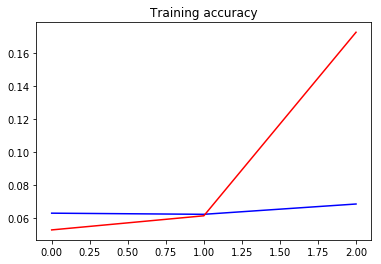

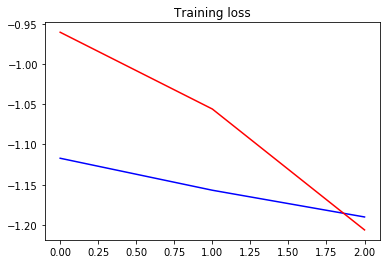

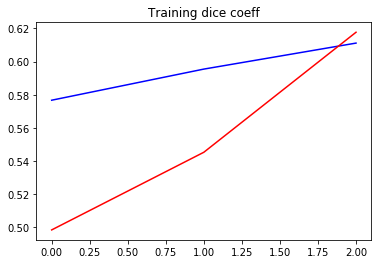

<Figure size 432x288 with 0 Axes>

In [42]:
plot_training(history)

In [44]:
# this saves to unet_model_128x800_unsharp_4classes_v1

PATIENCE = 2
EPOCHS = 5

idx = int(0.80*len(df_train))
dataGen_train = ImgDataGenerator_V3_4(df_train.iloc[:idx], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE, 
                                    n_channels=3, n_classes=4, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5,
                                    #shear_range=1, #OK
                                    #zoom_range=[0.98,1.02], # OK
                                    #rotation_range=1, #OK
                                    #width_shift_range=0.01, height_shift_range=0.025,#OK
                                    horizontal_flip=True, vertical_flip=True, #OK
                                    shuffle=False)

dataGen_valid = ImgDataGenerator_V3_4(df_train.iloc[idx:], './input/severstal-steel-defect-detection/train_images/', 
                                    outcome_img_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH), batch_size = BATCH_SIZE,
                                    n_channels=3, n_classes=4, 
                                    img_normalize=False, img_center=False, img_standardize=False,
                                    use_unsharp_mask=True, unsharp_radius=4, unsharp_amount=1.5,
                                    shuffle=False)

history = advanced_model.fit_generator(dataGen_train,
                              epochs=EPOCHS,    
                              validation_data=dataGen_valid,
                              verbose=1,
                              shuffle=True,
                              callbacks = get_callback(PATIENCE)
                             )

Epoch 1/5


132/946 [===>..........................] - ETA: 30:25 - loss: -1.0384 - dice_coeff: 0.5418 - acc: 0.12 - ETA: 27:01 - loss: -0.7750 - dice_coeff: 0.4029 - acc: 0.06 - ETA: 25:59 - loss: -0.7263 - dice_coeff: 0.3945 - acc: 0.08 - ETA: 25:36 - loss: -0.7667 - dice_coeff: 0.4105 - acc: 0.08 - ETA: 25:17 - loss: -0.7485 - dice_coeff: 0.3978 - acc: 0.07 - ETA: 25:07 - loss: -0.7757 - dice_coeff: 0.4094 - acc: 0.06 - ETA: 24:56 - loss: -0.7944 - dice_coeff: 0.4196 - acc: 0.07 - ETA: 24:47 - loss: -0.8244 - dice_coeff: 0.4348 - acc: 0.07 - ETA: 24:44 - loss: -0.8772 - dice_coeff: 0.4591 - acc: 0.06 - ETA: 24:46 - loss: -0.8811 - dice_coeff: 0.4603 - acc: 0.06 - ETA: 24:37 - loss: -0.8889 - dice_coeff: 0.4646 - acc: 0.06 - ETA: 23:59 - loss: -0.9009 - dice_coeff: 0.4705 - acc: 0.06 - ETA: 23:31 - loss: -0.9289 - dice_coeff: 0.4834 - acc: 0.06 - ETA: 23:01 - loss: -0.9582 - dice_coeff: 0.4982 - acc: 0.06 - ETA: 22:32 - loss: -0.9938 - dice_coeff: 0.5156 - acc: 0.06 - ETA: 22:10 - loss: -1.0230 

264/946 [=======>......................] - ETA: 15:24 - loss: -1.1801 - dice_coeff: 0.6069 - acc: 0.07 - ETA: 15:23 - loss: -1.1815 - dice_coeff: 0.6076 - acc: 0.07 - ETA: 15:21 - loss: -1.1775 - dice_coeff: 0.6057 - acc: 0.07 - ETA: 15:21 - loss: -1.1793 - dice_coeff: 0.6066 - acc: 0.07 - ETA: 15:19 - loss: -1.1787 - dice_coeff: 0.6062 - acc: 0.07 - ETA: 15:18 - loss: -1.1782 - dice_coeff: 0.6059 - acc: 0.07 - ETA: 15:17 - loss: -1.1805 - dice_coeff: 0.6070 - acc: 0.07 - ETA: 15:16 - loss: -1.1821 - dice_coeff: 0.6077 - acc: 0.07 - ETA: 15:14 - loss: -1.1832 - dice_coeff: 0.6082 - acc: 0.07 - ETA: 15:13 - loss: -1.1827 - dice_coeff: 0.6080 - acc: 0.07 - ETA: 15:12 - loss: -1.1848 - dice_coeff: 0.6089 - acc: 0.07 - ETA: 15:11 - loss: -1.1872 - dice_coeff: 0.6100 - acc: 0.07 - ETA: 15:09 - loss: -1.1878 - dice_coeff: 0.6105 - acc: 0.07 - ETA: 15:08 - loss: -1.1905 - dice_coeff: 0.6117 - acc: 0.07 - ETA: 15:07 - loss: -1.1888 - dice_coeff: 0.6108 - acc: 0.07 - ETA: 15:06 - loss: -1.1848 

396/946 [===========>..................] - ETA: 12:46 - loss: -1.1864 - dice_coeff: 0.6096 - acc: 0.07 - ETA: 12:45 - loss: -1.1870 - dice_coeff: 0.6099 - acc: 0.07 - ETA: 12:44 - loss: -1.1870 - dice_coeff: 0.6099 - acc: 0.07 - ETA: 12:43 - loss: -1.1880 - dice_coeff: 0.6104 - acc: 0.07 - ETA: 12:42 - loss: -1.1868 - dice_coeff: 0.6098 - acc: 0.07 - ETA: 12:41 - loss: -1.1874 - dice_coeff: 0.6101 - acc: 0.07 - ETA: 12:40 - loss: -1.1867 - dice_coeff: 0.6098 - acc: 0.07 - ETA: 12:38 - loss: -1.1860 - dice_coeff: 0.6095 - acc: 0.07 - ETA: 12:37 - loss: -1.1842 - dice_coeff: 0.6086 - acc: 0.07 - ETA: 12:36 - loss: -1.1853 - dice_coeff: 0.6091 - acc: 0.07 - ETA: 12:35 - loss: -1.1848 - dice_coeff: 0.6089 - acc: 0.07 - ETA: 12:34 - loss: -1.1857 - dice_coeff: 0.6093 - acc: 0.07 - ETA: 12:33 - loss: -1.1855 - dice_coeff: 0.6091 - acc: 0.07 - ETA: 12:32 - loss: -1.1867 - dice_coeff: 0.6098 - acc: 0.07 - ETA: 12:30 - loss: -1.1873 - dice_coeff: 0.6101 - acc: 0.07 - ETA: 12:29 - loss: -1.1853 

528/946 [===============>..............] - ETA: 10:17 - loss: -1.1944 - dice_coeff: 0.6136 - acc: 0.07 - ETA: 10:16 - loss: -1.1937 - dice_coeff: 0.6132 - acc: 0.07 - ETA: 10:14 - loss: -1.1921 - dice_coeff: 0.6125 - acc: 0.07 - ETA: 10:13 - loss: -1.1920 - dice_coeff: 0.6125 - acc: 0.07 - ETA: 10:12 - loss: -1.1926 - dice_coeff: 0.6127 - acc: 0.07 - ETA: 10:11 - loss: -1.1926 - dice_coeff: 0.6127 - acc: 0.07 - ETA: 10:10 - loss: -1.1937 - dice_coeff: 0.6133 - acc: 0.07 - ETA: 10:09 - loss: -1.1927 - dice_coeff: 0.6128 - acc: 0.07 - ETA: 10:07 - loss: -1.1927 - dice_coeff: 0.6128 - acc: 0.07 - ETA: 10:06 - loss: -1.1934 - dice_coeff: 0.6131 - acc: 0.07 - ETA: 10:05 - loss: -1.1937 - dice_coeff: 0.6132 - acc: 0.07 - ETA: 10:04 - loss: -1.1944 - dice_coeff: 0.6136 - acc: 0.07 - ETA: 10:03 - loss: -1.1941 - dice_coeff: 0.6134 - acc: 0.07 - ETA: 10:02 - loss: -1.1934 - dice_coeff: 0.6130 - acc: 0.07 - ETA: 10:01 - loss: -1.1930 - dice_coeff: 0.6128 - acc: 0.07 - ETA: 9:59 - loss: -1.1931 -

660/946 [===================>..........] - ETA: 7:48 - loss: -1.1912 - dice_coeff: 0.6116 - acc: 0.073 - ETA: 7:47 - loss: -1.1904 - dice_coeff: 0.6112 - acc: 0.073 - ETA: 7:45 - loss: -1.1912 - dice_coeff: 0.6116 - acc: 0.073 - ETA: 7:44 - loss: -1.1912 - dice_coeff: 0.6116 - acc: 0.073 - ETA: 7:43 - loss: -1.1908 - dice_coeff: 0.6115 - acc: 0.073 - ETA: 7:42 - loss: -1.1912 - dice_coeff: 0.6116 - acc: 0.073 - ETA: 7:41 - loss: -1.1909 - dice_coeff: 0.6115 - acc: 0.073 - ETA: 7:40 - loss: -1.1906 - dice_coeff: 0.6114 - acc: 0.073 - ETA: 7:39 - loss: -1.1903 - dice_coeff: 0.6112 - acc: 0.073 - ETA: 7:38 - loss: -1.1891 - dice_coeff: 0.6107 - acc: 0.072 - ETA: 7:36 - loss: -1.1898 - dice_coeff: 0.6110 - acc: 0.072 - ETA: 7:35 - loss: -1.1904 - dice_coeff: 0.6113 - acc: 0.073 - ETA: 7:34 - loss: -1.1908 - dice_coeff: 0.6115 - acc: 0.072 - ETA: 7:33 - loss: -1.1909 - dice_coeff: 0.6115 - acc: 0.072 - ETA: 7:32 - loss: -1.1909 - dice_coeff: 0.6115 - acc: 0.072 - ETA: 7:31 - loss: -1.1902 -

792/946 [========================>.....] - ETA: 5:19 - loss: -1.1959 - dice_coeff: 0.6140 - acc: 0.072 - ETA: 5:18 - loss: -1.1961 - dice_coeff: 0.6141 - acc: 0.072 - ETA: 5:17 - loss: -1.1962 - dice_coeff: 0.6141 - acc: 0.072 - ETA: 5:16 - loss: -1.1966 - dice_coeff: 0.6144 - acc: 0.072 - ETA: 5:15 - loss: -1.1966 - dice_coeff: 0.6144 - acc: 0.072 - ETA: 5:14 - loss: -1.1970 - dice_coeff: 0.6145 - acc: 0.072 - ETA: 5:13 - loss: -1.1967 - dice_coeff: 0.6144 - acc: 0.072 - ETA: 5:11 - loss: -1.1965 - dice_coeff: 0.6143 - acc: 0.072 - ETA: 5:10 - loss: -1.1967 - dice_coeff: 0.6144 - acc: 0.072 - ETA: 5:09 - loss: -1.1964 - dice_coeff: 0.6142 - acc: 0.072 - ETA: 5:08 - loss: -1.1970 - dice_coeff: 0.6145 - acc: 0.072 - ETA: 5:07 - loss: -1.1963 - dice_coeff: 0.6142 - acc: 0.072 - ETA: 5:06 - loss: -1.1969 - dice_coeff: 0.6145 - acc: 0.072 - ETA: 5:05 - loss: -1.1966 - dice_coeff: 0.6143 - acc: 0.072 - ETA: 5:04 - loss: -1.1957 - dice_coeff: 0.6139 - acc: 0.072 - ETA: 5:02 - loss: -1.1959 -

925/946 [============================>.] - ETA: 2:51 - loss: -1.1967 - dice_coeff: 0.6142 - acc: 0.070 - ETA: 2:50 - loss: -1.1965 - dice_coeff: 0.6141 - acc: 0.070 - ETA: 2:49 - loss: -1.1954 - dice_coeff: 0.6136 - acc: 0.070 - ETA: 2:48 - loss: -1.1958 - dice_coeff: 0.6138 - acc: 0.070 - ETA: 2:47 - loss: -1.1956 - dice_coeff: 0.6137 - acc: 0.070 - ETA: 2:45 - loss: -1.1955 - dice_coeff: 0.6136 - acc: 0.070 - ETA: 2:44 - loss: -1.1957 - dice_coeff: 0.6137 - acc: 0.070 - ETA: 2:43 - loss: -1.1960 - dice_coeff: 0.6138 - acc: 0.070 - ETA: 2:42 - loss: -1.1949 - dice_coeff: 0.6134 - acc: 0.070 - ETA: 2:41 - loss: -1.1954 - dice_coeff: 0.6136 - acc: 0.070 - ETA: 2:40 - loss: -1.1956 - dice_coeff: 0.6137 - acc: 0.070 - ETA: 2:39 - loss: -1.1950 - dice_coeff: 0.6134 - acc: 0.070 - ETA: 2:38 - loss: -1.1951 - dice_coeff: 0.6134 - acc: 0.070 - ETA: 2:36 - loss: -1.1947 - dice_coeff: 0.6132 - acc: 0.070 - ETA: 2:35 - loss: -1.1952 - dice_coeff: 0.6134 - acc: 0.070 - ETA: 2:34 - loss: -1.1948 -

946/946 [==============================] - ETA: 22s - loss: -1.1941 - dice_coeff: 0.6129 - acc: 0.07 - ETA: 21s - loss: -1.1937 - dice_coeff: 0.6127 - acc: 0.07 - ETA: 20s - loss: -1.1937 - dice_coeff: 0.6128 - acc: 0.07 - ETA: 19s - loss: -1.1940 - dice_coeff: 0.6129 - acc: 0.07 - ETA: 17s - loss: -1.1933 - dice_coeff: 0.6125 - acc: 0.07 - ETA: 16s - loss: -1.1924 - dice_coeff: 0.6121 - acc: 0.07 - ETA: 15s - loss: -1.1916 - dice_coeff: 0.6117 - acc: 0.07 - ETA: 14s - loss: -1.1916 - dice_coeff: 0.6117 - acc: 0.07 - ETA: 13s - loss: -1.1914 - dice_coeff: 0.6116 - acc: 0.07 - ETA: 12s - loss: -1.1904 - dice_coeff: 0.6111 - acc: 0.07 - ETA: 11s - loss: -1.1903 - dice_coeff: 0.6111 - acc: 0.07 - ETA: 10s - loss: -1.1897 - dice_coeff: 0.6108 - acc: 0.07 - ETA: 8s - loss: -1.1898 - dice_coeff: 0.6108 - acc: 0.0704 - ETA: 7s - loss: -1.1896 - dice_coeff: 0.6107 - acc: 0.070 - ETA: 6s - loss: -1.1894 - dice_coeff: 0.6106 - acc: 0.070 - ETA: 5s - loss: -1.1892 - dice_coeff: 0.6105 - acc: 0.07

132/946 [===>..........................] - ETA: 7:23 - loss: -1.3166 - dice_coeff: 0.6751 - acc: 0.097 - ETA: 7:22 - loss: -1.3623 - dice_coeff: 0.6926 - acc: 0.070 - ETA: 7:26 - loss: -1.3053 - dice_coeff: 0.6649 - acc: 0.067 - ETA: 7:27 - loss: -1.3678 - dice_coeff: 0.6952 - acc: 0.068 - ETA: 7:25 - loss: -1.1970 - dice_coeff: 0.6156 - acc: 0.068 - ETA: 7:25 - loss: -1.1610 - dice_coeff: 0.5987 - acc: 0.068 - ETA: 7:24 - loss: -1.1006 - dice_coeff: 0.5704 - acc: 0.068 - ETA: 7:23 - loss: -1.1576 - dice_coeff: 0.5975 - acc: 0.070 - ETA: 7:24 - loss: -1.1954 - dice_coeff: 0.6151 - acc: 0.067 - ETA: 7:24 - loss: -1.1680 - dice_coeff: 0.6001 - acc: 0.062 - ETA: 7:25 - loss: -1.1934 - dice_coeff: 0.6125 - acc: 0.063 - ETA: 7:23 - loss: -1.1979 - dice_coeff: 0.6143 - acc: 0.062 - ETA: 7:23 - loss: -1.2226 - dice_coeff: 0.6260 - acc: 0.063 - ETA: 7:23 - loss: -1.2293 - dice_coeff: 0.6294 - acc: 0.062 - ETA: 7:23 - loss: -1.2150 - dice_coeff: 0.6226 - acc: 0.063 - ETA: 8:03 - loss: -1.2254 -

264/946 [=======>......................] - ETA: 14:21 - loss: -1.2338 - dice_coeff: 0.6321 - acc: 0.07 - ETA: 14:20 - loss: -1.2357 - dice_coeff: 0.6331 - acc: 0.07 - ETA: 14:20 - loss: -1.2376 - dice_coeff: 0.6339 - acc: 0.06 - ETA: 14:19 - loss: -1.2395 - dice_coeff: 0.6348 - acc: 0.06 - ETA: 14:18 - loss: -1.2414 - dice_coeff: 0.6358 - acc: 0.06 - ETA: 14:17 - loss: -1.2432 - dice_coeff: 0.6366 - acc: 0.06 - ETA: 14:17 - loss: -1.2435 - dice_coeff: 0.6367 - acc: 0.06 - ETA: 14:16 - loss: -1.2372 - dice_coeff: 0.6338 - acc: 0.06 - ETA: 14:15 - loss: -1.2374 - dice_coeff: 0.6339 - acc: 0.06 - ETA: 14:15 - loss: -1.2391 - dice_coeff: 0.6347 - acc: 0.06 - ETA: 14:14 - loss: -1.2361 - dice_coeff: 0.6333 - acc: 0.06 - ETA: 14:13 - loss: -1.2383 - dice_coeff: 0.6343 - acc: 0.06 - ETA: 14:12 - loss: -1.2395 - dice_coeff: 0.6349 - acc: 0.06 - ETA: 14:12 - loss: -1.2406 - dice_coeff: 0.6354 - acc: 0.06 - ETA: 14:11 - loss: -1.2421 - dice_coeff: 0.6361 - acc: 0.06 - ETA: 14:10 - loss: -1.2400 

396/946 [===========>..................] - ETA: 12:20 - loss: -1.2278 - dice_coeff: 0.6292 - acc: 0.07 - ETA: 12:19 - loss: -1.2288 - dice_coeff: 0.6297 - acc: 0.07 - ETA: 12:18 - loss: -1.2268 - dice_coeff: 0.6288 - acc: 0.07 - ETA: 12:17 - loss: -1.2267 - dice_coeff: 0.6288 - acc: 0.07 - ETA: 12:16 - loss: -1.2253 - dice_coeff: 0.6281 - acc: 0.07 - ETA: 12:15 - loss: -1.2231 - dice_coeff: 0.6270 - acc: 0.07 - ETA: 12:14 - loss: -1.2238 - dice_coeff: 0.6274 - acc: 0.07 - ETA: 12:13 - loss: -1.2236 - dice_coeff: 0.6273 - acc: 0.07 - ETA: 12:12 - loss: -1.2233 - dice_coeff: 0.6271 - acc: 0.07 - ETA: 12:11 - loss: -1.2245 - dice_coeff: 0.6277 - acc: 0.07 - ETA: 12:10 - loss: -1.2255 - dice_coeff: 0.6282 - acc: 0.07 - ETA: 12:08 - loss: -1.2253 - dice_coeff: 0.6280 - acc: 0.07 - ETA: 12:07 - loss: -1.2256 - dice_coeff: 0.6282 - acc: 0.07 - ETA: 12:06 - loss: -1.2234 - dice_coeff: 0.6271 - acc: 0.07 - ETA: 12:05 - loss: -1.2235 - dice_coeff: 0.6272 - acc: 0.07 - ETA: 12:04 - loss: -1.2240 

528/946 [===============>..............] - ETA: 10:01 - loss: -1.2147 - dice_coeff: 0.6231 - acc: 0.07 - ETA: 10:00 - loss: -1.2146 - dice_coeff: 0.6230 - acc: 0.07 - ETA: 9:59 - loss: -1.2156 - dice_coeff: 0.6235 - acc: 0.0733 - ETA: 9:58 - loss: -1.2158 - dice_coeff: 0.6236 - acc: 0.073 - ETA: 9:57 - loss: -1.2146 - dice_coeff: 0.6230 - acc: 0.073 - ETA: 9:56 - loss: -1.2144 - dice_coeff: 0.6229 - acc: 0.073 - ETA: 9:55 - loss: -1.2130 - dice_coeff: 0.6223 - acc: 0.073 - ETA: 9:54 - loss: -1.2137 - dice_coeff: 0.6226 - acc: 0.073 - ETA: 9:53 - loss: -1.2125 - dice_coeff: 0.6221 - acc: 0.073 - ETA: 9:52 - loss: -1.2116 - dice_coeff: 0.6216 - acc: 0.073 - ETA: 9:51 - loss: -1.2127 - dice_coeff: 0.6222 - acc: 0.073 - ETA: 9:49 - loss: -1.2130 - dice_coeff: 0.6223 - acc: 0.073 - ETA: 9:48 - loss: -1.2131 - dice_coeff: 0.6224 - acc: 0.073 - ETA: 9:47 - loss: -1.2137 - dice_coeff: 0.6227 - acc: 0.073 - ETA: 9:46 - loss: -1.2129 - dice_coeff: 0.6222 - acc: 0.073 - ETA: 9:45 - loss: -1.2113 

660/946 [===================>..........] - ETA: 7:39 - loss: -1.2127 - dice_coeff: 0.6222 - acc: 0.075 - ETA: 7:38 - loss: -1.2120 - dice_coeff: 0.6218 - acc: 0.075 - ETA: 7:37 - loss: -1.2116 - dice_coeff: 0.6216 - acc: 0.075 - ETA: 7:35 - loss: -1.2123 - dice_coeff: 0.6220 - acc: 0.075 - ETA: 7:34 - loss: -1.2125 - dice_coeff: 0.6221 - acc: 0.075 - ETA: 7:33 - loss: -1.2110 - dice_coeff: 0.6213 - acc: 0.075 - ETA: 7:32 - loss: -1.2107 - dice_coeff: 0.6212 - acc: 0.075 - ETA: 7:31 - loss: -1.2106 - dice_coeff: 0.6212 - acc: 0.075 - ETA: 7:30 - loss: -1.2104 - dice_coeff: 0.6211 - acc: 0.075 - ETA: 7:29 - loss: -1.2105 - dice_coeff: 0.6211 - acc: 0.075 - ETA: 7:28 - loss: -1.2106 - dice_coeff: 0.6211 - acc: 0.075 - ETA: 7:27 - loss: -1.2096 - dice_coeff: 0.6206 - acc: 0.074 - ETA: 7:26 - loss: -1.2086 - dice_coeff: 0.6201 - acc: 0.074 - ETA: 7:25 - loss: -1.2086 - dice_coeff: 0.6201 - acc: 0.074 - ETA: 7:23 - loss: -1.2083 - dice_coeff: 0.6200 - acc: 0.074 - ETA: 7:22 - loss: -1.2081 -

792/946 [========================>.....] - ETA: 5:14 - loss: -1.2115 - dice_coeff: 0.6212 - acc: 0.075 - ETA: 5:13 - loss: -1.2112 - dice_coeff: 0.6211 - acc: 0.075 - ETA: 5:12 - loss: -1.2115 - dice_coeff: 0.6212 - acc: 0.075 - ETA: 5:11 - loss: -1.2119 - dice_coeff: 0.6214 - acc: 0.075 - ETA: 5:10 - loss: -1.2107 - dice_coeff: 0.6209 - acc: 0.075 - ETA: 5:09 - loss: -1.2105 - dice_coeff: 0.6208 - acc: 0.075 - ETA: 5:07 - loss: -1.2105 - dice_coeff: 0.6208 - acc: 0.075 - ETA: 5:06 - loss: -1.2111 - dice_coeff: 0.6211 - acc: 0.075 - ETA: 5:05 - loss: -1.2115 - dice_coeff: 0.6212 - acc: 0.075 - ETA: 5:04 - loss: -1.2121 - dice_coeff: 0.6215 - acc: 0.075 - ETA: 5:03 - loss: -1.2127 - dice_coeff: 0.6218 - acc: 0.075 - ETA: 5:02 - loss: -1.2126 - dice_coeff: 0.6217 - acc: 0.075 - ETA: 5:01 - loss: -1.2126 - dice_coeff: 0.6217 - acc: 0.075 - ETA: 5:00 - loss: -1.2121 - dice_coeff: 0.6215 - acc: 0.075 - ETA: 4:59 - loss: -1.2115 - dice_coeff: 0.6212 - acc: 0.075 - ETA: 4:58 - loss: -1.2116 -

925/946 [============================>.] - ETA: 2:49 - loss: -1.2135 - dice_coeff: 0.6221 - acc: 0.075 - ETA: 2:48 - loss: -1.2135 - dice_coeff: 0.6221 - acc: 0.075 - ETA: 2:46 - loss: -1.2140 - dice_coeff: 0.6223 - acc: 0.075 - ETA: 2:45 - loss: -1.2138 - dice_coeff: 0.6222 - acc: 0.075 - ETA: 2:44 - loss: -1.2143 - dice_coeff: 0.6224 - acc: 0.075 - ETA: 2:43 - loss: -1.2144 - dice_coeff: 0.6225 - acc: 0.075 - ETA: 2:42 - loss: -1.2148 - dice_coeff: 0.6227 - acc: 0.075 - ETA: 2:41 - loss: -1.2151 - dice_coeff: 0.6228 - acc: 0.075 - ETA: 2:40 - loss: -1.2150 - dice_coeff: 0.6228 - acc: 0.075 - ETA: 2:39 - loss: -1.2149 - dice_coeff: 0.6227 - acc: 0.075 - ETA: 2:38 - loss: -1.2147 - dice_coeff: 0.6226 - acc: 0.075 - ETA: 2:37 - loss: -1.2149 - dice_coeff: 0.6228 - acc: 0.075 - ETA: 2:35 - loss: -1.2153 - dice_coeff: 0.6230 - acc: 0.075 - ETA: 2:34 - loss: -1.2156 - dice_coeff: 0.6231 - acc: 0.075 - ETA: 2:33 - loss: -1.2157 - dice_coeff: 0.6231 - acc: 0.075 - ETA: 2:32 - loss: -1.2155 -

946/946 [==============================] - ETA: 22s - loss: -1.2175 - dice_coeff: 0.6240 - acc: 0.07 - ETA: 21s - loss: -1.2169 - dice_coeff: 0.6237 - acc: 0.07 - ETA: 19s - loss: -1.2167 - dice_coeff: 0.6236 - acc: 0.07 - ETA: 18s - loss: -1.2170 - dice_coeff: 0.6237 - acc: 0.07 - ETA: 17s - loss: -1.2171 - dice_coeff: 0.6238 - acc: 0.07 - ETA: 16s - loss: -1.2166 - dice_coeff: 0.6236 - acc: 0.07 - ETA: 15s - loss: -1.2166 - dice_coeff: 0.6236 - acc: 0.07 - ETA: 14s - loss: -1.2170 - dice_coeff: 0.6238 - acc: 0.07 - ETA: 13s - loss: -1.2172 - dice_coeff: 0.6239 - acc: 0.07 - ETA: 12s - loss: -1.2173 - dice_coeff: 0.6239 - acc: 0.07 - ETA: 11s - loss: -1.2173 - dice_coeff: 0.6239 - acc: 0.07 - ETA: 9s - loss: -1.2171 - dice_coeff: 0.6238 - acc: 0.0757 - ETA: 8s - loss: -1.2165 - dice_coeff: 0.6235 - acc: 0.075 - ETA: 7s - loss: -1.2167 - dice_coeff: 0.6236 - acc: 0.075 - ETA: 6s - loss: -1.2168 - dice_coeff: 0.6237 - acc: 0.075 - ETA: 5s - loss: -1.2166 - dice_coeff: 0.6236 - acc: 0.07

132/946 [===>..........................] - ETA: 7:18 - loss: -1.0604 - dice_coeff: 0.5364 - acc: 0.021 - ETA: 7:26 - loss: -1.2067 - dice_coeff: 0.6213 - acc: 0.136 - ETA: 7:23 - loss: -1.0673 - dice_coeff: 0.5543 - acc: 0.110 - ETA: 7:19 - loss: -1.1400 - dice_coeff: 0.5886 - acc: 0.111 - ETA: 7:24 - loss: -1.0510 - dice_coeff: 0.5452 - acc: 0.104 - ETA: 7:23 - loss: -1.1173 - dice_coeff: 0.5778 - acc: 0.104 - ETA: 7:24 - loss: -1.1072 - dice_coeff: 0.5743 - acc: 0.104 - ETA: 7:25 - loss: -1.1573 - dice_coeff: 0.5979 - acc: 0.099 - ETA: 7:22 - loss: -1.1847 - dice_coeff: 0.6123 - acc: 0.110 - ETA: 7:21 - loss: -1.2098 - dice_coeff: 0.6240 - acc: 0.107 - ETA: 7:21 - loss: -1.2092 - dice_coeff: 0.6235 - acc: 0.104 - ETA: 7:22 - loss: -1.2008 - dice_coeff: 0.6194 - acc: 0.107 - ETA: 7:21 - loss: -1.1769 - dice_coeff: 0.6068 - acc: 0.100 - ETA: 7:20 - loss: -1.1650 - dice_coeff: 0.5999 - acc: 0.094 - ETA: 7:19 - loss: -1.1822 - dice_coeff: 0.6079 - acc: 0.090 - ETA: 8:05 - loss: -1.1935 -

264/946 [=======>......................] - ETA: 14:26 - loss: -1.2386 - dice_coeff: 0.6339 - acc: 0.07 - ETA: 14:25 - loss: -1.2352 - dice_coeff: 0.6323 - acc: 0.07 - ETA: 14:25 - loss: -1.2318 - dice_coeff: 0.6306 - acc: 0.07 - ETA: 14:24 - loss: -1.2319 - dice_coeff: 0.6307 - acc: 0.07 - ETA: 14:23 - loss: -1.2314 - dice_coeff: 0.6305 - acc: 0.07 - ETA: 14:22 - loss: -1.2313 - dice_coeff: 0.6303 - acc: 0.07 - ETA: 14:22 - loss: -1.2321 - dice_coeff: 0.6307 - acc: 0.07 - ETA: 14:21 - loss: -1.2272 - dice_coeff: 0.6283 - acc: 0.07 - ETA: 14:20 - loss: -1.2279 - dice_coeff: 0.6286 - acc: 0.07 - ETA: 14:19 - loss: -1.2282 - dice_coeff: 0.6287 - acc: 0.07 - ETA: 14:18 - loss: -1.2254 - dice_coeff: 0.6274 - acc: 0.07 - ETA: 14:18 - loss: -1.2258 - dice_coeff: 0.6278 - acc: 0.07 - ETA: 14:18 - loss: -1.2241 - dice_coeff: 0.6270 - acc: 0.07 - ETA: 14:17 - loss: -1.2238 - dice_coeff: 0.6268 - acc: 0.07 - ETA: 14:16 - loss: -1.2240 - dice_coeff: 0.6269 - acc: 0.07 - ETA: 14:15 - loss: -1.2228 

396/946 [===========>..................] - ETA: 12:22 - loss: -1.2359 - dice_coeff: 0.6326 - acc: 0.07 - ETA: 12:21 - loss: -1.2361 - dice_coeff: 0.6326 - acc: 0.07 - ETA: 12:20 - loss: -1.2371 - dice_coeff: 0.6331 - acc: 0.07 - ETA: 12:19 - loss: -1.2377 - dice_coeff: 0.6334 - acc: 0.07 - ETA: 12:18 - loss: -1.2381 - dice_coeff: 0.6336 - acc: 0.07 - ETA: 12:17 - loss: -1.2393 - dice_coeff: 0.6342 - acc: 0.07 - ETA: 12:16 - loss: -1.2407 - dice_coeff: 0.6348 - acc: 0.07 - ETA: 12:15 - loss: -1.2416 - dice_coeff: 0.6353 - acc: 0.07 - ETA: 12:15 - loss: -1.2425 - dice_coeff: 0.6357 - acc: 0.07 - ETA: 12:14 - loss: -1.2421 - dice_coeff: 0.6355 - acc: 0.07 - ETA: 12:13 - loss: -1.2415 - dice_coeff: 0.6352 - acc: 0.07 - ETA: 12:12 - loss: -1.2388 - dice_coeff: 0.6339 - acc: 0.07 - ETA: 12:10 - loss: -1.2398 - dice_coeff: 0.6344 - acc: 0.07 - ETA: 12:09 - loss: -1.2399 - dice_coeff: 0.6344 - acc: 0.07 - ETA: 12:08 - loss: -1.2401 - dice_coeff: 0.6344 - acc: 0.07 - ETA: 12:07 - loss: -1.2394 

528/946 [===============>..............] - ETA: 10:04 - loss: -1.2329 - dice_coeff: 0.6312 - acc: 0.07 - ETA: 10:02 - loss: -1.2330 - dice_coeff: 0.6312 - acc: 0.07 - ETA: 10:01 - loss: -1.2334 - dice_coeff: 0.6314 - acc: 0.07 - ETA: 10:00 - loss: -1.2319 - dice_coeff: 0.6307 - acc: 0.07 - ETA: 9:59 - loss: -1.2318 - dice_coeff: 0.6306 - acc: 0.0725 - ETA: 9:58 - loss: -1.2318 - dice_coeff: 0.6306 - acc: 0.072 - ETA: 9:57 - loss: -1.2310 - dice_coeff: 0.6302 - acc: 0.072 - ETA: 9:56 - loss: -1.2306 - dice_coeff: 0.6300 - acc: 0.072 - ETA: 9:55 - loss: -1.2305 - dice_coeff: 0.6300 - acc: 0.072 - ETA: 9:54 - loss: -1.2303 - dice_coeff: 0.6298 - acc: 0.072 - ETA: 9:53 - loss: -1.2296 - dice_coeff: 0.6295 - acc: 0.072 - ETA: 9:52 - loss: -1.2286 - dice_coeff: 0.6290 - acc: 0.072 - ETA: 9:51 - loss: -1.2284 - dice_coeff: 0.6289 - acc: 0.072 - ETA: 9:50 - loss: -1.2293 - dice_coeff: 0.6293 - acc: 0.072 - ETA: 9:48 - loss: -1.2294 - dice_coeff: 0.6294 - acc: 0.072 - ETA: 9:47 - loss: -1.2292 

660/946 [===================>..........] - ETA: 7:40 - loss: -1.2358 - dice_coeff: 0.6326 - acc: 0.075 - ETA: 7:39 - loss: -1.2364 - dice_coeff: 0.6328 - acc: 0.075 - ETA: 7:38 - loss: -1.2370 - dice_coeff: 0.6331 - acc: 0.075 - ETA: 7:37 - loss: -1.2375 - dice_coeff: 0.6333 - acc: 0.075 - ETA: 7:36 - loss: -1.2378 - dice_coeff: 0.6335 - acc: 0.075 - ETA: 7:35 - loss: -1.2368 - dice_coeff: 0.6330 - acc: 0.075 - ETA: 7:33 - loss: -1.2363 - dice_coeff: 0.6328 - acc: 0.075 - ETA: 7:32 - loss: -1.2365 - dice_coeff: 0.6328 - acc: 0.074 - ETA: 7:31 - loss: -1.2368 - dice_coeff: 0.6330 - acc: 0.074 - ETA: 7:30 - loss: -1.2372 - dice_coeff: 0.6331 - acc: 0.074 - ETA: 7:29 - loss: -1.2370 - dice_coeff: 0.6331 - acc: 0.074 - ETA: 7:28 - loss: -1.2374 - dice_coeff: 0.6333 - acc: 0.074 - ETA: 7:27 - loss: -1.2361 - dice_coeff: 0.6327 - acc: 0.074 - ETA: 7:26 - loss: -1.2350 - dice_coeff: 0.6322 - acc: 0.074 - ETA: 7:25 - loss: -1.2356 - dice_coeff: 0.6325 - acc: 0.074 - ETA: 7:24 - loss: -1.2351 -

792/946 [========================>.....] - ETA: 5:15 - loss: -1.2316 - dice_coeff: 0.6307 - acc: 0.076 - ETA: 5:14 - loss: -1.2311 - dice_coeff: 0.6305 - acc: 0.076 - ETA: 5:13 - loss: -1.2303 - dice_coeff: 0.6301 - acc: 0.076 - ETA: 5:12 - loss: -1.2302 - dice_coeff: 0.6300 - acc: 0.076 - ETA: 5:11 - loss: -1.2301 - dice_coeff: 0.6300 - acc: 0.076 - ETA: 5:09 - loss: -1.2300 - dice_coeff: 0.6299 - acc: 0.076 - ETA: 5:08 - loss: -1.2302 - dice_coeff: 0.6300 - acc: 0.076 - ETA: 5:07 - loss: -1.2303 - dice_coeff: 0.6301 - acc: 0.076 - ETA: 5:06 - loss: -1.2307 - dice_coeff: 0.6302 - acc: 0.076 - ETA: 5:05 - loss: -1.2308 - dice_coeff: 0.6303 - acc: 0.076 - ETA: 5:04 - loss: -1.2306 - dice_coeff: 0.6302 - acc: 0.076 - ETA: 5:03 - loss: -1.2302 - dice_coeff: 0.6300 - acc: 0.076 - ETA: 5:02 - loss: -1.2300 - dice_coeff: 0.6299 - acc: 0.076 - ETA: 5:01 - loss: -1.2298 - dice_coeff: 0.6298 - acc: 0.076 - ETA: 5:00 - loss: -1.2300 - dice_coeff: 0.6300 - acc: 0.076 - ETA: 4:58 - loss: -1.2303 -

925/946 [============================>.] - ETA: 2:49 - loss: -1.2349 - dice_coeff: 0.6325 - acc: 0.079 - ETA: 2:48 - loss: -1.2346 - dice_coeff: 0.6323 - acc: 0.079 - ETA: 2:47 - loss: -1.2349 - dice_coeff: 0.6325 - acc: 0.079 - ETA: 2:46 - loss: -1.2348 - dice_coeff: 0.6324 - acc: 0.079 - ETA: 2:45 - loss: -1.2349 - dice_coeff: 0.6325 - acc: 0.079 - ETA: 2:44 - loss: -1.2353 - dice_coeff: 0.6327 - acc: 0.079 - ETA: 2:43 - loss: -1.2354 - dice_coeff: 0.6328 - acc: 0.079 - ETA: 2:41 - loss: -1.2348 - dice_coeff: 0.6325 - acc: 0.079 - ETA: 2:40 - loss: -1.2348 - dice_coeff: 0.6325 - acc: 0.079 - ETA: 2:39 - loss: -1.2350 - dice_coeff: 0.6325 - acc: 0.079 - ETA: 2:38 - loss: -1.2352 - dice_coeff: 0.6326 - acc: 0.079 - ETA: 2:37 - loss: -1.2355 - dice_coeff: 0.6328 - acc: 0.079 - ETA: 2:36 - loss: -1.2359 - dice_coeff: 0.6330 - acc: 0.079 - ETA: 2:35 - loss: -1.2358 - dice_coeff: 0.6329 - acc: 0.079 - ETA: 2:34 - loss: -1.2360 - dice_coeff: 0.6330 - acc: 0.079 - ETA: 2:33 - loss: -1.2359 -

946/946 [==============================] - ETA: 22s - loss: -1.2346 - dice_coeff: 0.6323 - acc: 0.08 - ETA: 21s - loss: -1.2349 - dice_coeff: 0.6324 - acc: 0.08 - ETA: 19s - loss: -1.2352 - dice_coeff: 0.6325 - acc: 0.08 - ETA: 18s - loss: -1.2352 - dice_coeff: 0.6326 - acc: 0.08 - ETA: 17s - loss: -1.2353 - dice_coeff: 0.6326 - acc: 0.08 - ETA: 16s - loss: -1.2352 - dice_coeff: 0.6326 - acc: 0.08 - ETA: 15s - loss: -1.2350 - dice_coeff: 0.6325 - acc: 0.08 - ETA: 14s - loss: -1.2347 - dice_coeff: 0.6323 - acc: 0.08 - ETA: 13s - loss: -1.2349 - dice_coeff: 0.6324 - acc: 0.08 - ETA: 12s - loss: -1.2350 - dice_coeff: 0.6325 - acc: 0.08 - ETA: 11s - loss: -1.2354 - dice_coeff: 0.6326 - acc: 0.08 - ETA: 9s - loss: -1.2351 - dice_coeff: 0.6325 - acc: 0.0801 - ETA: 8s - loss: -1.2353 - dice_coeff: 0.6326 - acc: 0.080 - ETA: 7s - loss: -1.2355 - dice_coeff: 0.6327 - acc: 0.080 - ETA: 6s - loss: -1.2354 - dice_coeff: 0.6327 - acc: 0.080 - ETA: 5s - loss: -1.2353 - dice_coeff: 0.6326 - acc: 0.08

132/946 [===>..........................] - ETA: 7:32 - loss: -1.3950 - dice_coeff: 0.7066 - acc: 0.061 - ETA: 7:34 - loss: -1.4294 - dice_coeff: 0.7251 - acc: 0.077 - ETA: 7:32 - loss: -1.2591 - dice_coeff: 0.6428 - acc: 0.077 - ETA: 7:33 - loss: -1.2580 - dice_coeff: 0.6428 - acc: 0.086 - ETA: 7:33 - loss: -1.2837 - dice_coeff: 0.6556 - acc: 0.087 - ETA: 7:31 - loss: -1.2525 - dice_coeff: 0.6405 - acc: 0.086 - ETA: 7:31 - loss: -1.2569 - dice_coeff: 0.6419 - acc: 0.079 - ETA: 7:31 - loss: -1.2836 - dice_coeff: 0.6544 - acc: 0.077 - ETA: 7:30 - loss: -1.2754 - dice_coeff: 0.6494 - acc: 0.070 - ETA: 7:28 - loss: -1.3074 - dice_coeff: 0.6648 - acc: 0.068 - ETA: 7:27 - loss: -1.2849 - dice_coeff: 0.6549 - acc: 0.069 - ETA: 7:25 - loss: -1.2421 - dice_coeff: 0.6355 - acc: 0.072 - ETA: 7:25 - loss: -1.2659 - dice_coeff: 0.6471 - acc: 0.075 - ETA: 7:24 - loss: -1.2492 - dice_coeff: 0.6392 - acc: 0.075 - ETA: 7:23 - loss: -1.2545 - dice_coeff: 0.6415 - acc: 0.075 - ETA: 8:03 - loss: -1.2556 -

264/946 [=======>......................] - ETA: 14:22 - loss: -1.2705 - dice_coeff: 0.6499 - acc: 0.08 - ETA: 14:21 - loss: -1.2697 - dice_coeff: 0.6497 - acc: 0.08 - ETA: 14:20 - loss: -1.2701 - dice_coeff: 0.6498 - acc: 0.08 - ETA: 14:19 - loss: -1.2702 - dice_coeff: 0.6500 - acc: 0.08 - ETA: 14:18 - loss: -1.2724 - dice_coeff: 0.6511 - acc: 0.08 - ETA: 14:17 - loss: -1.2719 - dice_coeff: 0.6508 - acc: 0.08 - ETA: 14:16 - loss: -1.2741 - dice_coeff: 0.6519 - acc: 0.08 - ETA: 14:16 - loss: -1.2721 - dice_coeff: 0.6508 - acc: 0.08 - ETA: 14:14 - loss: -1.2696 - dice_coeff: 0.6496 - acc: 0.08 - ETA: 14:14 - loss: -1.2724 - dice_coeff: 0.6509 - acc: 0.08 - ETA: 14:13 - loss: -1.2716 - dice_coeff: 0.6505 - acc: 0.08 - ETA: 14:13 - loss: -1.2731 - dice_coeff: 0.6512 - acc: 0.08 - ETA: 14:12 - loss: -1.2692 - dice_coeff: 0.6492 - acc: 0.08 - ETA: 14:11 - loss: -1.2659 - dice_coeff: 0.6478 - acc: 0.08 - ETA: 14:10 - loss: -1.2662 - dice_coeff: 0.6479 - acc: 0.08 - ETA: 14:10 - loss: -1.2679 

396/946 [===========>..................] - ETA: 12:21 - loss: -1.2671 - dice_coeff: 0.6478 - acc: 0.08 - ETA: 12:21 - loss: -1.2663 - dice_coeff: 0.6474 - acc: 0.08 - ETA: 12:20 - loss: -1.2661 - dice_coeff: 0.6474 - acc: 0.08 - ETA: 12:19 - loss: -1.2665 - dice_coeff: 0.6475 - acc: 0.08 - ETA: 12:18 - loss: -1.2648 - dice_coeff: 0.6467 - acc: 0.08 - ETA: 12:17 - loss: -1.2646 - dice_coeff: 0.6466 - acc: 0.08 - ETA: 12:16 - loss: -1.2649 - dice_coeff: 0.6469 - acc: 0.08 - ETA: 12:15 - loss: -1.2651 - dice_coeff: 0.6469 - acc: 0.08 - ETA: 12:14 - loss: -1.2641 - dice_coeff: 0.6464 - acc: 0.08 - ETA: 12:13 - loss: -1.2644 - dice_coeff: 0.6466 - acc: 0.08 - ETA: 12:12 - loss: -1.2639 - dice_coeff: 0.6464 - acc: 0.08 - ETA: 12:10 - loss: -1.2649 - dice_coeff: 0.6468 - acc: 0.08 - ETA: 12:09 - loss: -1.2644 - dice_coeff: 0.6467 - acc: 0.08 - ETA: 12:08 - loss: -1.2620 - dice_coeff: 0.6456 - acc: 0.08 - ETA: 12:07 - loss: -1.2616 - dice_coeff: 0.6454 - acc: 0.08 - ETA: 12:06 - loss: -1.2601 

528/946 [===============>..............] - ETA: 10:03 - loss: -1.2656 - dice_coeff: 0.6473 - acc: 0.08 - ETA: 10:02 - loss: -1.2660 - dice_coeff: 0.6475 - acc: 0.08 - ETA: 10:01 - loss: -1.2668 - dice_coeff: 0.6479 - acc: 0.08 - ETA: 10:00 - loss: -1.2677 - dice_coeff: 0.6483 - acc: 0.08 - ETA: 9:59 - loss: -1.2680 - dice_coeff: 0.6485 - acc: 0.0830 - ETA: 9:58 - loss: -1.2677 - dice_coeff: 0.6483 - acc: 0.082 - ETA: 9:57 - loss: -1.2674 - dice_coeff: 0.6482 - acc: 0.082 - ETA: 9:56 - loss: -1.2682 - dice_coeff: 0.6485 - acc: 0.083 - ETA: 9:54 - loss: -1.2683 - dice_coeff: 0.6486 - acc: 0.082 - ETA: 9:53 - loss: -1.2685 - dice_coeff: 0.6487 - acc: 0.082 - ETA: 9:52 - loss: -1.2688 - dice_coeff: 0.6488 - acc: 0.082 - ETA: 9:51 - loss: -1.2684 - dice_coeff: 0.6486 - acc: 0.082 - ETA: 9:50 - loss: -1.2675 - dice_coeff: 0.6482 - acc: 0.082 - ETA: 9:49 - loss: -1.2677 - dice_coeff: 0.6483 - acc: 0.083 - ETA: 9:48 - loss: -1.2683 - dice_coeff: 0.6486 - acc: 0.083 - ETA: 9:47 - loss: -1.2680 

660/946 [===================>..........] - ETA: 7:40 - loss: -1.2600 - dice_coeff: 0.6448 - acc: 0.084 - ETA: 7:39 - loss: -1.2596 - dice_coeff: 0.6446 - acc: 0.084 - ETA: 7:38 - loss: -1.2604 - dice_coeff: 0.6450 - acc: 0.084 - ETA: 7:37 - loss: -1.2611 - dice_coeff: 0.6454 - acc: 0.084 - ETA: 7:36 - loss: -1.2618 - dice_coeff: 0.6457 - acc: 0.084 - ETA: 7:35 - loss: -1.2619 - dice_coeff: 0.6457 - acc: 0.083 - ETA: 7:33 - loss: -1.2619 - dice_coeff: 0.6457 - acc: 0.083 - ETA: 7:32 - loss: -1.2617 - dice_coeff: 0.6456 - acc: 0.083 - ETA: 7:31 - loss: -1.2608 - dice_coeff: 0.6452 - acc: 0.084 - ETA: 7:30 - loss: -1.2614 - dice_coeff: 0.6455 - acc: 0.084 - ETA: 7:29 - loss: -1.2617 - dice_coeff: 0.6457 - acc: 0.084 - ETA: 7:28 - loss: -1.2609 - dice_coeff: 0.6453 - acc: 0.084 - ETA: 7:27 - loss: -1.2613 - dice_coeff: 0.6455 - acc: 0.084 - ETA: 7:26 - loss: -1.2614 - dice_coeff: 0.6456 - acc: 0.084 - ETA: 7:25 - loss: -1.2620 - dice_coeff: 0.6459 - acc: 0.084 - ETA: 7:24 - loss: -1.2615 -

792/946 [========================>.....] - ETA: 5:15 - loss: -1.2540 - dice_coeff: 0.6418 - acc: 0.084 - ETA: 5:14 - loss: -1.2533 - dice_coeff: 0.6415 - acc: 0.084 - ETA: 5:13 - loss: -1.2536 - dice_coeff: 0.6416 - acc: 0.085 - ETA: 5:12 - loss: -1.2535 - dice_coeff: 0.6416 - acc: 0.085 - ETA: 5:11 - loss: -1.2541 - dice_coeff: 0.6419 - acc: 0.085 - ETA: 5:10 - loss: -1.2547 - dice_coeff: 0.6421 - acc: 0.085 - ETA: 5:08 - loss: -1.2542 - dice_coeff: 0.6419 - acc: 0.085 - ETA: 5:07 - loss: -1.2536 - dice_coeff: 0.6416 - acc: 0.084 - ETA: 5:06 - loss: -1.2535 - dice_coeff: 0.6415 - acc: 0.084 - ETA: 5:05 - loss: -1.2536 - dice_coeff: 0.6416 - acc: 0.084 - ETA: 5:04 - loss: -1.2534 - dice_coeff: 0.6415 - acc: 0.084 - ETA: 5:03 - loss: -1.2527 - dice_coeff: 0.6411 - acc: 0.084 - ETA: 5:02 - loss: -1.2528 - dice_coeff: 0.6412 - acc: 0.084 - ETA: 5:01 - loss: -1.2528 - dice_coeff: 0.6412 - acc: 0.084 - ETA: 5:00 - loss: -1.2533 - dice_coeff: 0.6414 - acc: 0.084 - ETA: 4:58 - loss: -1.2526 -

925/946 [============================>.] - ETA: 2:49 - loss: -1.2550 - dice_coeff: 0.6422 - acc: 0.083 - ETA: 2:48 - loss: -1.2548 - dice_coeff: 0.6421 - acc: 0.083 - ETA: 2:47 - loss: -1.2551 - dice_coeff: 0.6422 - acc: 0.083 - ETA: 2:46 - loss: -1.2552 - dice_coeff: 0.6422 - acc: 0.083 - ETA: 2:45 - loss: -1.2550 - dice_coeff: 0.6421 - acc: 0.083 - ETA: 2:44 - loss: -1.2550 - dice_coeff: 0.6421 - acc: 0.083 - ETA: 2:43 - loss: -1.2551 - dice_coeff: 0.6422 - acc: 0.083 - ETA: 2:41 - loss: -1.2551 - dice_coeff: 0.6422 - acc: 0.083 - ETA: 2:40 - loss: -1.2552 - dice_coeff: 0.6422 - acc: 0.083 - ETA: 2:39 - loss: -1.2555 - dice_coeff: 0.6424 - acc: 0.083 - ETA: 2:38 - loss: -1.2559 - dice_coeff: 0.6426 - acc: 0.083 - ETA: 2:37 - loss: -1.2562 - dice_coeff: 0.6427 - acc: 0.083 - ETA: 2:36 - loss: -1.2562 - dice_coeff: 0.6427 - acc: 0.083 - ETA: 2:35 - loss: -1.2559 - dice_coeff: 0.6426 - acc: 0.083 - ETA: 2:34 - loss: -1.2554 - dice_coeff: 0.6423 - acc: 0.083 - ETA: 2:33 - loss: -1.2557 -

946/946 [==============================] - ETA: 22s - loss: -1.2518 - dice_coeff: 0.6406 - acc: 0.08 - ETA: 21s - loss: -1.2510 - dice_coeff: 0.6402 - acc: 0.08 - ETA: 19s - loss: -1.2512 - dice_coeff: 0.6403 - acc: 0.08 - ETA: 18s - loss: -1.2513 - dice_coeff: 0.6404 - acc: 0.08 - ETA: 17s - loss: -1.2514 - dice_coeff: 0.6405 - acc: 0.08 - ETA: 16s - loss: -1.2510 - dice_coeff: 0.6403 - acc: 0.08 - ETA: 15s - loss: -1.2514 - dice_coeff: 0.6404 - acc: 0.08 - ETA: 14s - loss: -1.2506 - dice_coeff: 0.6401 - acc: 0.08 - ETA: 13s - loss: -1.2510 - dice_coeff: 0.6403 - acc: 0.08 - ETA: 12s - loss: -1.2507 - dice_coeff: 0.6401 - acc: 0.08 - ETA: 11s - loss: -1.2507 - dice_coeff: 0.6401 - acc: 0.08 - ETA: 9s - loss: -1.2503 - dice_coeff: 0.6399 - acc: 0.0830 - ETA: 8s - loss: -1.2502 - dice_coeff: 0.6399 - acc: 0.083 - ETA: 7s - loss: -1.2502 - dice_coeff: 0.6399 - acc: 0.083 - ETA: 6s - loss: -1.2501 - dice_coeff: 0.6398 - acc: 0.083 - ETA: 5s - loss: -1.2503 - dice_coeff: 0.6399 - acc: 0.08

132/946 [===>..........................] - ETA: 7:11 - loss: -1.5208 - dice_coeff: 0.7741 - acc: 0.107 - ETA: 7:22 - loss: -1.4556 - dice_coeff: 0.7374 - acc: 0.072 - ETA: 7:21 - loss: -1.2790 - dice_coeff: 0.6523 - acc: 0.064 - ETA: 7:21 - loss: -1.3042 - dice_coeff: 0.6647 - acc: 0.068 - ETA: 7:20 - loss: -1.3160 - dice_coeff: 0.6699 - acc: 0.061 - ETA: 7:22 - loss: -1.3624 - dice_coeff: 0.6925 - acc: 0.064 - ETA: 7:25 - loss: -1.3460 - dice_coeff: 0.6850 - acc: 0.066 - ETA: 7:22 - loss: -1.3315 - dice_coeff: 0.6771 - acc: 0.062 - ETA: 7:21 - loss: -1.3356 - dice_coeff: 0.6802 - acc: 0.069 - ETA: 7:20 - loss: -1.3431 - dice_coeff: 0.6842 - acc: 0.072 - ETA: 7:21 - loss: -1.3114 - dice_coeff: 0.6690 - acc: 0.072 - ETA: 7:20 - loss: -1.3433 - dice_coeff: 0.6843 - acc: 0.075 - ETA: 7:19 - loss: -1.3337 - dice_coeff: 0.6790 - acc: 0.071 - ETA: 7:19 - loss: -1.3547 - dice_coeff: 0.6891 - acc: 0.072 - ETA: 7:18 - loss: -1.3353 - dice_coeff: 0.6792 - acc: 0.070 - ETA: 8:09 - loss: -1.3377 -

264/946 [=======>......................] - ETA: 14:24 - loss: -1.2861 - dice_coeff: 0.6562 - acc: 0.06 - ETA: 14:23 - loss: -1.2799 - dice_coeff: 0.6531 - acc: 0.06 - ETA: 14:22 - loss: -1.2816 - dice_coeff: 0.6540 - acc: 0.07 - ETA: 14:21 - loss: -1.2849 - dice_coeff: 0.6556 - acc: 0.07 - ETA: 14:20 - loss: -1.2860 - dice_coeff: 0.6561 - acc: 0.07 - ETA: 14:20 - loss: -1.2851 - dice_coeff: 0.6557 - acc: 0.07 - ETA: 14:19 - loss: -1.2831 - dice_coeff: 0.6547 - acc: 0.07 - ETA: 14:18 - loss: -1.2838 - dice_coeff: 0.6550 - acc: 0.07 - ETA: 14:17 - loss: -1.2814 - dice_coeff: 0.6539 - acc: 0.07 - ETA: 14:16 - loss: -1.2814 - dice_coeff: 0.6538 - acc: 0.07 - ETA: 14:15 - loss: -1.2789 - dice_coeff: 0.6526 - acc: 0.07 - ETA: 14:15 - loss: -1.2803 - dice_coeff: 0.6532 - acc: 0.07 - ETA: 14:14 - loss: -1.2798 - dice_coeff: 0.6530 - acc: 0.07 - ETA: 14:13 - loss: -1.2806 - dice_coeff: 0.6536 - acc: 0.07 - ETA: 14:12 - loss: -1.2808 - dice_coeff: 0.6536 - acc: 0.07 - ETA: 14:11 - loss: -1.2809 

396/946 [===========>..................] - ETA: 12:21 - loss: -1.2481 - dice_coeff: 0.6385 - acc: 0.07 - ETA: 12:20 - loss: -1.2490 - dice_coeff: 0.6389 - acc: 0.07 - ETA: 12:19 - loss: -1.2508 - dice_coeff: 0.6398 - acc: 0.07 - ETA: 12:18 - loss: -1.2523 - dice_coeff: 0.6405 - acc: 0.07 - ETA: 12:17 - loss: -1.2534 - dice_coeff: 0.6410 - acc: 0.07 - ETA: 12:16 - loss: -1.2537 - dice_coeff: 0.6412 - acc: 0.07 - ETA: 12:15 - loss: -1.2545 - dice_coeff: 0.6416 - acc: 0.07 - ETA: 12:14 - loss: -1.2540 - dice_coeff: 0.6413 - acc: 0.07 - ETA: 12:13 - loss: -1.2540 - dice_coeff: 0.6413 - acc: 0.07 - ETA: 12:12 - loss: -1.2547 - dice_coeff: 0.6416 - acc: 0.07 - ETA: 12:11 - loss: -1.2538 - dice_coeff: 0.6412 - acc: 0.07 - ETA: 12:10 - loss: -1.2543 - dice_coeff: 0.6414 - acc: 0.07 - ETA: 12:09 - loss: -1.2546 - dice_coeff: 0.6416 - acc: 0.07 - ETA: 12:08 - loss: -1.2546 - dice_coeff: 0.6416 - acc: 0.07 - ETA: 12:07 - loss: -1.2534 - dice_coeff: 0.6410 - acc: 0.07 - ETA: 12:06 - loss: -1.2530 

528/946 [===============>..............] - ETA: 10:03 - loss: -1.2529 - dice_coeff: 0.6409 - acc: 0.08 - ETA: 10:02 - loss: -1.2533 - dice_coeff: 0.6411 - acc: 0.08 - ETA: 10:01 - loss: -1.2530 - dice_coeff: 0.6409 - acc: 0.08 - ETA: 10:00 - loss: -1.2540 - dice_coeff: 0.6414 - acc: 0.08 - ETA: 9:59 - loss: -1.2533 - dice_coeff: 0.6410 - acc: 0.0812 - ETA: 9:58 - loss: -1.2530 - dice_coeff: 0.6409 - acc: 0.081 - ETA: 9:57 - loss: -1.2524 - dice_coeff: 0.6406 - acc: 0.081 - ETA: 9:56 - loss: -1.2529 - dice_coeff: 0.6408 - acc: 0.081 - ETA: 9:55 - loss: -1.2531 - dice_coeff: 0.6409 - acc: 0.081 - ETA: 9:54 - loss: -1.2533 - dice_coeff: 0.6410 - acc: 0.081 - ETA: 9:53 - loss: -1.2525 - dice_coeff: 0.6406 - acc: 0.081 - ETA: 9:52 - loss: -1.2521 - dice_coeff: 0.6404 - acc: 0.081 - ETA: 9:51 - loss: -1.2530 - dice_coeff: 0.6409 - acc: 0.081 - ETA: 9:49 - loss: -1.2539 - dice_coeff: 0.6413 - acc: 0.081 - ETA: 9:48 - loss: -1.2537 - dice_coeff: 0.6412 - acc: 0.081 - ETA: 9:47 - loss: -1.2529 

660/946 [===================>..........] - ETA: 7:40 - loss: -1.2513 - dice_coeff: 0.6401 - acc: 0.082 - ETA: 7:39 - loss: -1.2518 - dice_coeff: 0.6403 - acc: 0.082 - ETA: 7:38 - loss: -1.2525 - dice_coeff: 0.6407 - acc: 0.082 - ETA: 7:37 - loss: -1.2515 - dice_coeff: 0.6402 - acc: 0.082 - ETA: 7:36 - loss: -1.2521 - dice_coeff: 0.6405 - acc: 0.082 - ETA: 7:35 - loss: -1.2527 - dice_coeff: 0.6408 - acc: 0.082 - ETA: 7:34 - loss: -1.2533 - dice_coeff: 0.6411 - acc: 0.082 - ETA: 7:33 - loss: -1.2533 - dice_coeff: 0.6411 - acc: 0.082 - ETA: 7:32 - loss: -1.2538 - dice_coeff: 0.6413 - acc: 0.082 - ETA: 7:30 - loss: -1.2541 - dice_coeff: 0.6415 - acc: 0.082 - ETA: 7:29 - loss: -1.2543 - dice_coeff: 0.6416 - acc: 0.082 - ETA: 7:28 - loss: -1.2541 - dice_coeff: 0.6415 - acc: 0.082 - ETA: 7:27 - loss: -1.2548 - dice_coeff: 0.6419 - acc: 0.082 - ETA: 7:26 - loss: -1.2556 - dice_coeff: 0.6422 - acc: 0.082 - ETA: 7:25 - loss: -1.2556 - dice_coeff: 0.6422 - acc: 0.082 - ETA: 7:24 - loss: -1.2539 -

792/946 [========================>.....] - ETA: 5:15 - loss: -1.2582 - dice_coeff: 0.6436 - acc: 0.083 - ETA: 5:14 - loss: -1.2586 - dice_coeff: 0.6438 - acc: 0.083 - ETA: 5:13 - loss: -1.2583 - dice_coeff: 0.6436 - acc: 0.083 - ETA: 5:12 - loss: -1.2582 - dice_coeff: 0.6436 - acc: 0.083 - ETA: 5:11 - loss: -1.2586 - dice_coeff: 0.6438 - acc: 0.083 - ETA: 5:10 - loss: -1.2590 - dice_coeff: 0.6440 - acc: 0.083 - ETA: 5:09 - loss: -1.2592 - dice_coeff: 0.6440 - acc: 0.083 - ETA: 5:08 - loss: -1.2593 - dice_coeff: 0.6441 - acc: 0.083 - ETA: 5:06 - loss: -1.2598 - dice_coeff: 0.6444 - acc: 0.083 - ETA: 5:05 - loss: -1.2598 - dice_coeff: 0.6444 - acc: 0.083 - ETA: 5:04 - loss: -1.2599 - dice_coeff: 0.6445 - acc: 0.083 - ETA: 5:03 - loss: -1.2603 - dice_coeff: 0.6447 - acc: 0.083 - ETA: 5:02 - loss: -1.2605 - dice_coeff: 0.6447 - acc: 0.083 - ETA: 5:01 - loss: -1.2600 - dice_coeff: 0.6445 - acc: 0.083 - ETA: 5:00 - loss: -1.2603 - dice_coeff: 0.6447 - acc: 0.084 - ETA: 4:59 - loss: -1.2605 -

925/946 [============================>.] - ETA: 2:49 - loss: -1.2690 - dice_coeff: 0.6488 - acc: 0.082 - ETA: 2:48 - loss: -1.2692 - dice_coeff: 0.6489 - acc: 0.082 - ETA: 2:47 - loss: -1.2697 - dice_coeff: 0.6492 - acc: 0.082 - ETA: 2:46 - loss: -1.2692 - dice_coeff: 0.6489 - acc: 0.082 - ETA: 2:45 - loss: -1.2689 - dice_coeff: 0.6488 - acc: 0.082 - ETA: 2:44 - loss: -1.2692 - dice_coeff: 0.6489 - acc: 0.082 - ETA: 2:43 - loss: -1.2691 - dice_coeff: 0.6489 - acc: 0.082 - ETA: 2:41 - loss: -1.2692 - dice_coeff: 0.6489 - acc: 0.082 - ETA: 2:40 - loss: -1.2691 - dice_coeff: 0.6489 - acc: 0.082 - ETA: 2:39 - loss: -1.2692 - dice_coeff: 0.6489 - acc: 0.082 - ETA: 2:38 - loss: -1.2693 - dice_coeff: 0.6490 - acc: 0.082 - ETA: 2:37 - loss: -1.2688 - dice_coeff: 0.6487 - acc: 0.082 - ETA: 2:36 - loss: -1.2692 - dice_coeff: 0.6489 - acc: 0.082 - ETA: 2:35 - loss: -1.2694 - dice_coeff: 0.6490 - acc: 0.082 - ETA: 2:34 - loss: -1.2698 - dice_coeff: 0.6492 - acc: 0.082 - ETA: 2:33 - loss: -1.2701 -

946/946 [==============================] - ETA: 22s - loss: -1.2656 - dice_coeff: 0.6471 - acc: 0.08 - ETA: 21s - loss: -1.2656 - dice_coeff: 0.6472 - acc: 0.08 - ETA: 19s - loss: -1.2657 - dice_coeff: 0.6472 - acc: 0.08 - ETA: 18s - loss: -1.2659 - dice_coeff: 0.6473 - acc: 0.08 - ETA: 17s - loss: -1.2661 - dice_coeff: 0.6474 - acc: 0.08 - ETA: 16s - loss: -1.2654 - dice_coeff: 0.6470 - acc: 0.08 - ETA: 15s - loss: -1.2651 - dice_coeff: 0.6469 - acc: 0.08 - ETA: 14s - loss: -1.2654 - dice_coeff: 0.6470 - acc: 0.08 - ETA: 13s - loss: -1.2656 - dice_coeff: 0.6471 - acc: 0.08 - ETA: 12s - loss: -1.2654 - dice_coeff: 0.6470 - acc: 0.08 - ETA: 11s - loss: -1.2659 - dice_coeff: 0.6473 - acc: 0.08 - ETA: 9s - loss: -1.2660 - dice_coeff: 0.6473 - acc: 0.0832 - ETA: 8s - loss: -1.2663 - dice_coeff: 0.6475 - acc: 0.083 - ETA: 7s - loss: -1.2663 - dice_coeff: 0.6475 - acc: 0.083 - ETA: 6s - loss: -1.2662 - dice_coeff: 0.6474 - acc: 0.083 - ETA: 5s - loss: -1.2659 - dice_coeff: 0.6473 - acc: 0.08

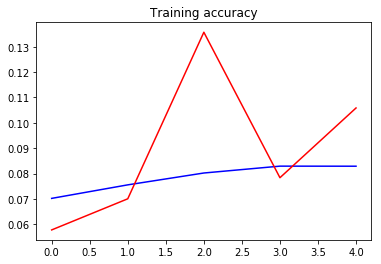

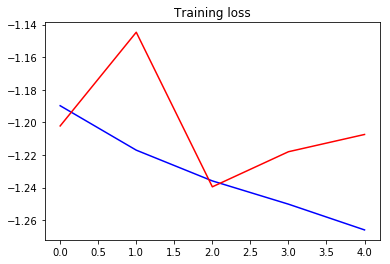

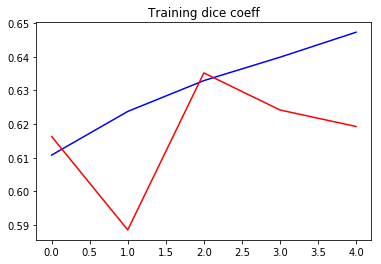

<Figure size 432x288 with 0 Axes>

In [45]:
plot_training(history)